# Prompt 4 - Global Data Quantum, BasQ (Beginner) BY COSMO WU
## **Upgrading** Elitzur-Vaidman Bomb Tester and **Extending** it to Battleship Grid

### Installation

First, install the necessary Qiskit libraries for this project.

In [1]:
!pip install qiskit[visualization] qiskit-ibm-runtime qiskit-aer qiskit_qasm3_import

import numpy as np
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter, ParameterVector
import qiskit.qasm3
from qiskit.circuit.library import MCXGate, RXGate
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, QiskitRuntimeService


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.5/541.5 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.2 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=3daf5b3fca1ffe8a18e2a1844c0253d7476960bed9d281c649ccce634f3a7468
  Stored i

## Introducing The Elitzur-Vaidman Bomb Tester in Qiskit

The Elitzur-Vaidman Bomb Tester was a thought experiment developed by Avshalom Elitzur and Lev Vaidman. The idea is that by using quantum supposition, entanglement, and state collapse, it would be possible to check for the presence of a bomb without detecting it.

The core idea is to gain information about an object without any direct interaction.
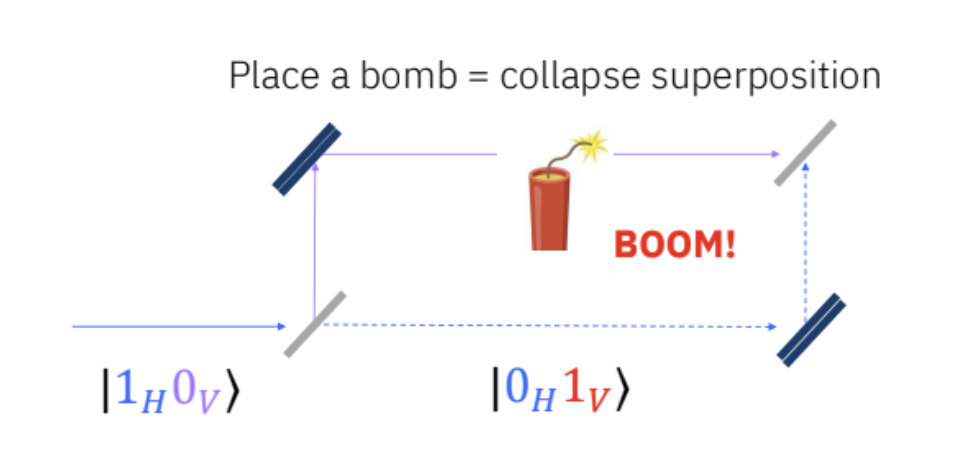

We can simulate this in Qiskit with $2$ qubits and $2$ classical bits.

### Circuit 1 - Simulating the Bomb Tester

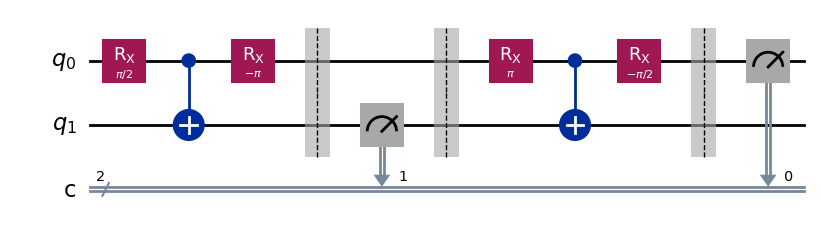

In [2]:
# 2 qubits, 2 classical bits
qc = QuantumCircuit(2, 2)

# This step is to imitate splitting a photon down two different paths, similar to the physical experiment (Mach-Zehnder interferometer)
qc.rx(np.pi / 2, 0)

# Entangling the first qubit with the second
qc.cx(0, 1)

qc.rx(-np.pi, 0)

qc.barrier()

# Measure qubit 1 to classical bit 1
# If we measure 1 from classical bit 1, that means we have set off the bomb!
qc.measure(1, 1)

qc.barrier()

qc.rx(np.pi, 0)

qc.cx(0, 1)

qc.rx(-np.pi / 2, 0)

qc.barrier()

# Measure qubit 0 to classical bit 0
# If its value is 1, that confirms that there was a bomb.
# As if there wasn't a bomb, the end state of qubit 0 would be 0.
qc.measure(0, 0)

qc.draw("mpl")


#### Remarks 1 - About the circuit and how it works.

In the circuit shown above, the measurement for $q_1$ essentially represents the bomb while $q_0$ represents the photon traveling through the experiment. And whenever the measurement detects a $1$, that means the bomb does end up exploding from detecting a photon.

When considering the measured state of $q_0$, if it's equal to $0$, that means that the qubit followed its original path in the interferometer. However, if it is equal to $1$, that means there must have been a bomb. This is because if the qubit state is equal to $1$, then the photon (which is represented by $q_0$) experienced state collapse, causing it to not travel in its original direction when leaving the interferometer.

We can classify each of potential combinations of the measured bits in the following categories:
$$
\lvert 10  \rangle \text{ and }\lvert 11  \rangle \to \text{bomb explodes!}
\\
\lvert 01  \rangle \to \text{bomb founded!}
\\
\lvert 00  \rangle \to \text{no explosions!}
$$

Note that we have our notation such that the first digit represents $q_1$ and the second represents $q_0$. We now use the AerSimulator to find our results.

In [3]:
# Create the simulator and transpiler
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)

# Simulating the circuit
sim_result = simulator.run(compiled_circuit).result()
counts = sim_result.get_counts()
print(f'Measurement counts: {counts}')

Measurement counts: {'01': 272, '00': 238, '10': 234, '11': 280}


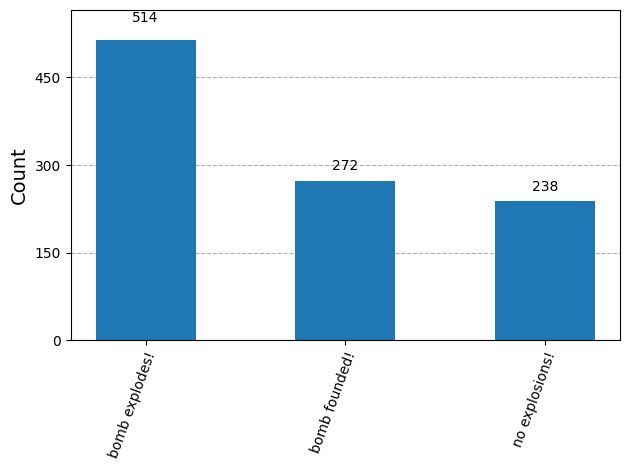

In [4]:
hist_data = {}
hist_data["bomb explodes!"] = counts["10"] + counts["11"]
hist_data["no explosions!"] = counts["00"]
hist_data["bomb founded!"] = counts["01"]
plot_histogram(hist_data)

#### Remarks 2 - About our results

Our results is consistent with the experiment, as it is expected that the percentage of times where the bomb does explode is $ ≈ 50 \%$ while the photon going through its original direction or in a different direction are both $ ≈ 25 \%$.

Notably, the non-zero percentage where the photon travels in a different direction is very significant, as it indicates that there was a bomb without igniting it.

We can increase this percentage by modifying the original set-up.

## Upgrading the Bomb Tester Design


### Circuit 2 - Modifying the Bomb Tester

In the previous circuit, we utilized the $R_x(\theta)$ gate which is
$$
R_x(\theta) = e^{-i\frac{\theta}{2}X} =
\begin{bmatrix}
\cos\!\left(\frac{\theta}{2}\right) & -i\sin\!\left(\frac{\theta}{2}\right) \\
-i\sin\!\left(\frac{\theta}{2}\right) & \cos\!\left(\frac{\theta}{2}\right)
\end{bmatrix}
$$

with $\theta = \pi / 2$. In order to decrease the percentage of times where the bomb explodes, we can change this angle $\theta$ to $ \pi /3 $.

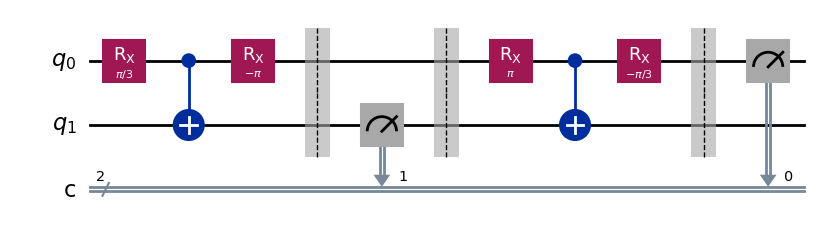

In [5]:
# With this change, we replicate the same exact ciruit.
theta = Parameter('θ')

# 2 qubits, 2 classical bits
qc = QuantumCircuit(2, 2)

# This step is to imitate splitting a photon down two different paths, similar to the physical experiment (Mach-Zehnder interferometer)
qc.rx(theta, 0)

# Entangling the first qubit with the second
qc.cx(0, 1)

qc.rx(-np.pi, 0)

qc.barrier()

# Measure qubit 1 to classical bit 1
# If we measure 1 from classical bit 1, that means we have set off the bomb!
qc.measure(1, 1)

qc.barrier()

qc.rx(np.pi, 0)

qc.cx(0, 1)

qc.rx(- theta, 0)

qc.barrier()

# Measure qubit 0 to classical bit 0
# If its value is 1, that confirms that there was a bomb.
qc.measure(0, 0)

qc = qc.assign_parameters({theta: np.pi/3})

qc.draw("mpl")


In [6]:
# Create the simulator and transpiler
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)

# Simulating the circuit
sim_result = simulator.run(compiled_circuit).result()
counts = sim_result.get_counts()
print(f'Measurement counts: {counts}')

Measurement counts: {'11': 190, '00': 560, '10': 78, '01': 196}


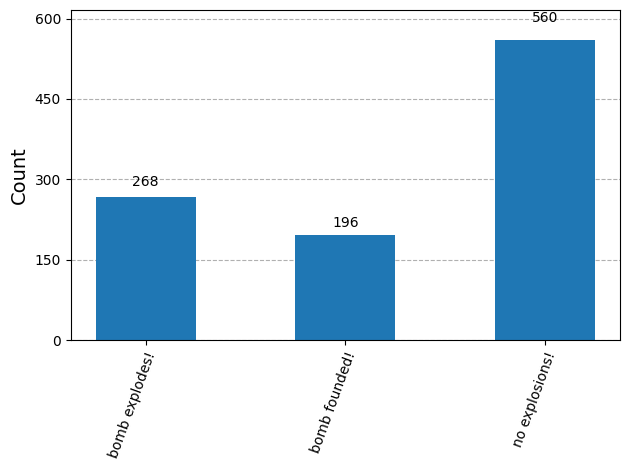

In [7]:
hist_data = {}
hist_data["bomb explodes!"] = counts["10"] + counts["11"]
hist_data["no explosions!"] = counts["00"]
hist_data["bomb founded!"] = counts["01"]
plot_histogram(hist_data)

#### Remarks 3 - About this upgrade

As shown, the chances of the bomb exploding has decreased to $\approx 25 \% $!

However, the probability can even be more minimized through the **Quantum Zeno Effect**, which is shown in our third and final circuit for this introduction section. It can reduce the probability of a bomb exploding very low while increasing the probability and frequency of the bomb founded occuring.

As shown in both circuit $1$ and $2$, the frequency of the bomb being found without the explosion is $ \approx 25 \%$, but by utilizing the **Quantum Zeno Effect**, it can be increased up to $100\%$ (or almost there).


### Circuit 3 - Utilizing the **Quantum Zeno Effect**

#### Defining the Quantum Zeno Effect on an Abstract Level:

On a more abstract level, the idea of this effect is that if you continuous measure a system after $ \Delta t$ where $ \Delta t$ is very small, then you are essentially slowing down the evolution of the quantum system.

A good way of understanding this is that **a watched pot never boils**, so a constantly measured quantum system never changes.
</br>
</br>
</br>
#### A Mathematically Rigorous Version of the Quantum Zeno Effect*:

Suppose we are measuring the quantum state of $$
\lvert \psi \rangle
$$ over the time interval from $ t =0$ to $ t = N ϵ$, and we make $N$ measurements over this time interval.

Now let the initial quantum state be $ \lvert \psi_0 \rangle
$ and its probability (**survival probability**) of being in that state when measured at $t = ϵ$ be $P(ϵ)$.

Then the probability of the system also being $ \lvert \psi_0 \rangle
$ at $ t = 2 ϵ $ is $P(2ϵ) = p^2$. It follows that $P(t) = P(Nϵ) = p^N$.

Consider $N \to \infty$, which means we measure the system many many times. We also have $ ϵ = \frac{t}{N} \to 0$ assuming $t$ is fixed.

Now recall that
$$ p = \lvert \langle \psi_0 \mid \psi_\epsilon \rangle \rvert^2 = \lvert \langle \psi_0 \mid U_ϵ \mid \psi_0 \rangle \rvert^2$$

But $$ U_ϵ = e^\frac{-iHϵ}{\hbar} \approx 1 - i\frac{ϵ}{\hbar}H - \frac{ϵ^2}{2\hbar^2}H^2+O(ϵ^3)$$
by Taylor Series approximation for our unitary matrix.
Thus, we have that

$$ p = 1 - \frac{σ^2}{\hbar^2}ϵ^2+O(ϵ^3)$$ where
$$ σ^2 =\langle \psi_0 \mid H^2\mid \psi_0 \rangle - \langle \psi_0 \mid H\mid \psi_0 \rangle ^ 2$$

Finally, as $N \to ∞$ and $ϵ \to 0$ ,
$$p^N = (1 - \frac{σ^2}{\hbar^2}ϵ^2+O(ϵ^3))^N = (1 - \frac{σ^2 t^2}{\hbar^2}N^{-2}+O(N^{-3}))^N \to 1$$

This means that $P(t) \to 1$ as $N \to ∞$. Thus, if we make infinitely many measurements over this time interval, the survival proability or the probability the quantum system remains the same is $1$, demonstrating the Quantum Zeno Effect.
</br>
</br>
*Source for the mathematical version: https://youtu.be/lgYDb7gKhKM?si=-eXbWNtU3QPLtnFt* *


#### Remarks 4 - Applying the Quantum Zeno Effect

Now that we have explained the Quantum Zeno Effect, it is time to apply it to our bomb tester. In order to do this, we measure the bomb qubit after every tiny rotation, to collapse the bomb back into its initial state before the explosion can complete.

#### Explaining this circuit design

To understand this design, similar to the previous designs, each of the $R_x$ gates can be thought of as our beam splitters. But this time, they are beam splitters that are very reflective as shown in the image below. If there is a bomb, each time the photon goes towards the beam splitter, it is very likely for it to be reflected due to state collapse. For this reason, the measurement we want to get is where $q_0 = 0$ at the end, as that state means that the qubit has been reflected numerous times and takes the reflective path. Meanwhile, if the measured result is $q_0 = 1$, then that means the qubit likely simply interferred with itself, indicating there was no bomb.
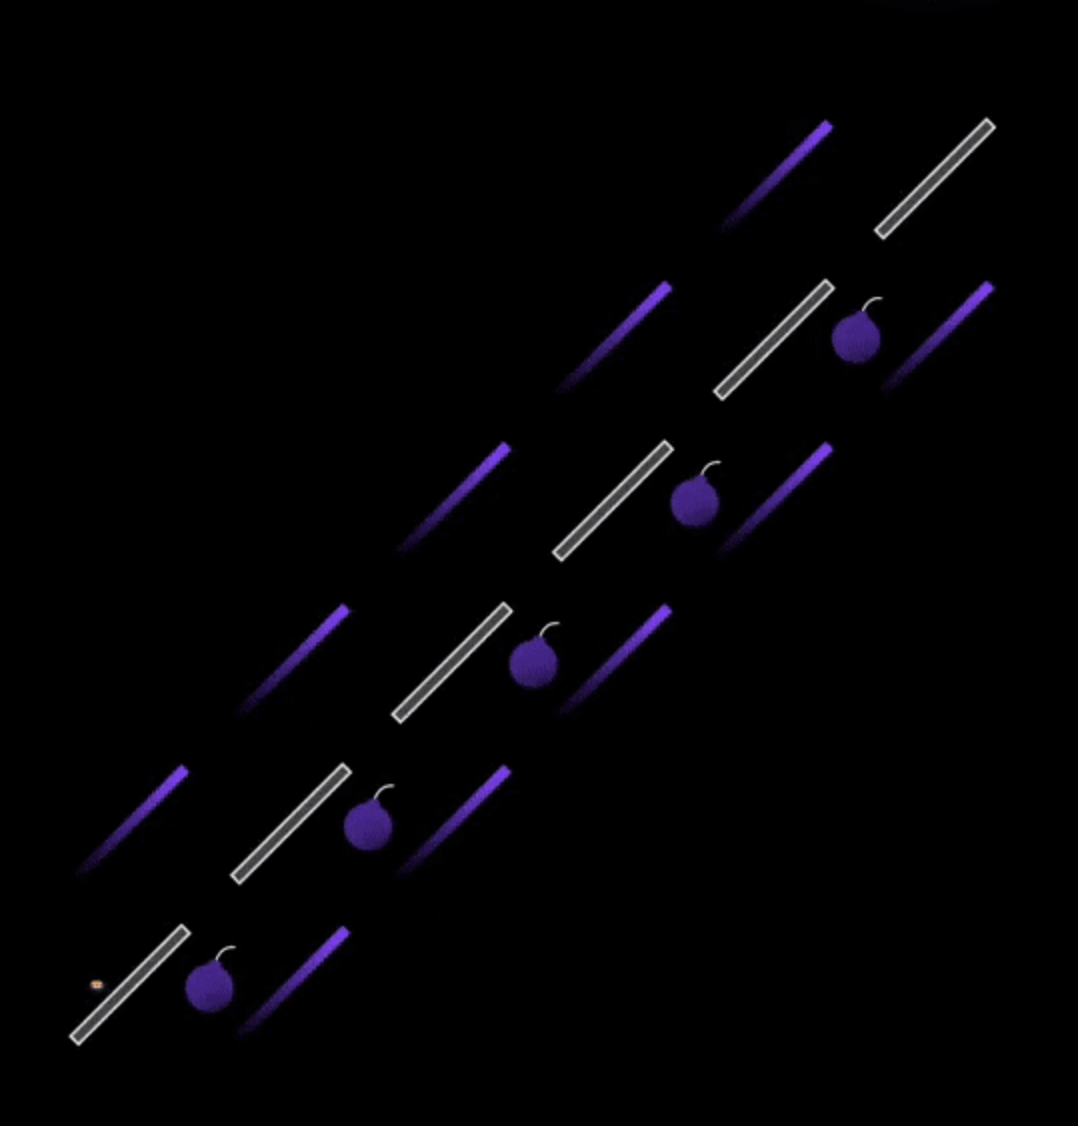

</br>

Credit for the image: https://youtu.be/fus1nJ6JaTk?si=X2oxbdkdRacOavOo





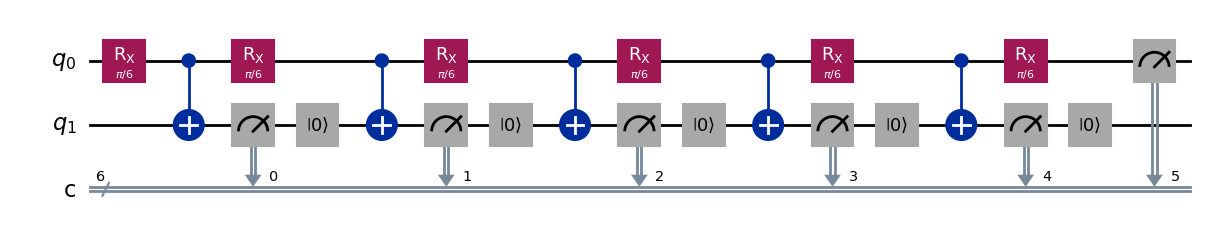

In [8]:
# This can also be consiered the number of times we "measure" the bomb. The more cycles the better.
cycles = 6
theta = np.pi / cycles

# we will need cycles classical bits for measuring
qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(cycles, 'c')
qc = QuantumCircuit(qr, cr)

# Adding the "beam splitters"
for cycle in range(cycles - 1):
    qc.append(RXGate(theta), [qr[0]])
    qc.cx(0, 1)
    # Checking the state of our bomb
    qc.measure(qr[1],cr[cycle])
    qc.reset(qr[1])

# Final beam splitter
qc.append(RXGate(theta), [qr[0]])

qc.measure(qr[0], cr[cycles - 1])

qc.draw("mpl")

In [9]:
# Create the simulator and transpiler
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)

# Simulating the circuit
sim_result = simulator.run(compiled_circuit, shots = 2000).result()
counts = sim_result.get_counts()
print(f'Measurement counts: {counts}')

Measurement counts: {'001000': 5, '000110': 3, '110110': 2, '111001': 1, '010000': 10, '100001': 2, '001110': 3, '001111': 8, '000010': 7, '011110': 13, '100110': 1, '000000': 1304, '111100': 102, '111111': 91, '100000': 103, '110000': 82, '001100': 10, '000100': 11, '000111': 5, '111000': 103, '000011': 9, '110111': 1, '011101': 1, '010010': 1, '111110': 88, '011100': 6, '000001': 8, '011111': 12, '011000': 8}


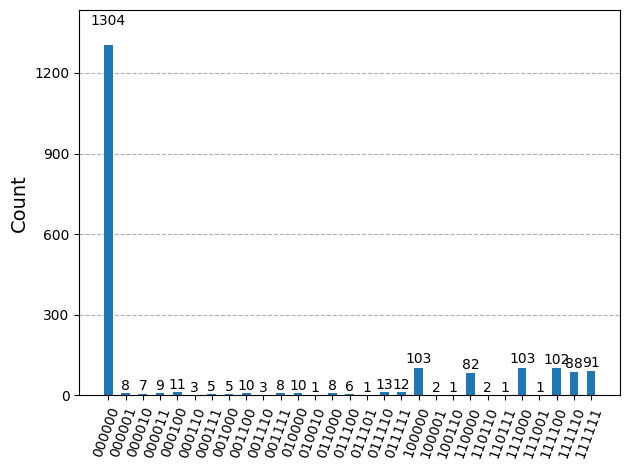

In [10]:
plot_histogram(counts)

#### Remarks 5 - Assisting the Results
Recall that our goal was to find the case where all the measured bits are $0$, as that indicates no bombs exploded and $q_0 = 0$, meaning there are bombs. Thus, by utilizing the Quantum Zeno Effect, we can achieve the most optimal output.

## Extending the Bomb Tester Into a Battleship Game

The goal of this section is to simulate the process of detecting where the ships are in an $N \times N $ grid. For the sake of simplicity, we first tackle $N = 4$. We then have the following grid

$$
\begin{array}{|c|c|c|c|c|}
& A & B & C & D \\
\hline
1 & & & & \\
\hline
2 & & & X & \\
\hline
3 & & & & \\
\hline
4 & & & & \\
\hline
\end{array}
$$

The $X$ represents that there is a ship there. In order to detect where the ships are, classically, we go through every single square, resulting in $O(N^2)$ operations. However, with quantum computing, we can reduce this to $O(N)$ by measuring whether there is a ship in each of the row and columns. We do this similar to how we have done this with the bomb tester. We can think of each ship as a "bomb detector." We redraw the $N \times N$ grid as such:
$$
\begin{array}{|c|c|c|c|c|}
& A & B & C & D \\
\hline
1 & q_1& q_2 & q_3 & q_4 \\
\hline
2 & q_5 & q_6 & q_7 & q_8 \\
\hline
3 & q_9 & q_{10}& q_{11}& q_{12} \\
\hline
4 & q_{13}& q_{14} & q_{15}& q_{16}\\
\hline
\end{array}
$$

Similar to the previous circuits, we use $q_0$ as a photon going through a row/column to track if there is any bombs. We test this with column $A$. Note that we use the words bombs and ships interchangeably for the rest of the code.

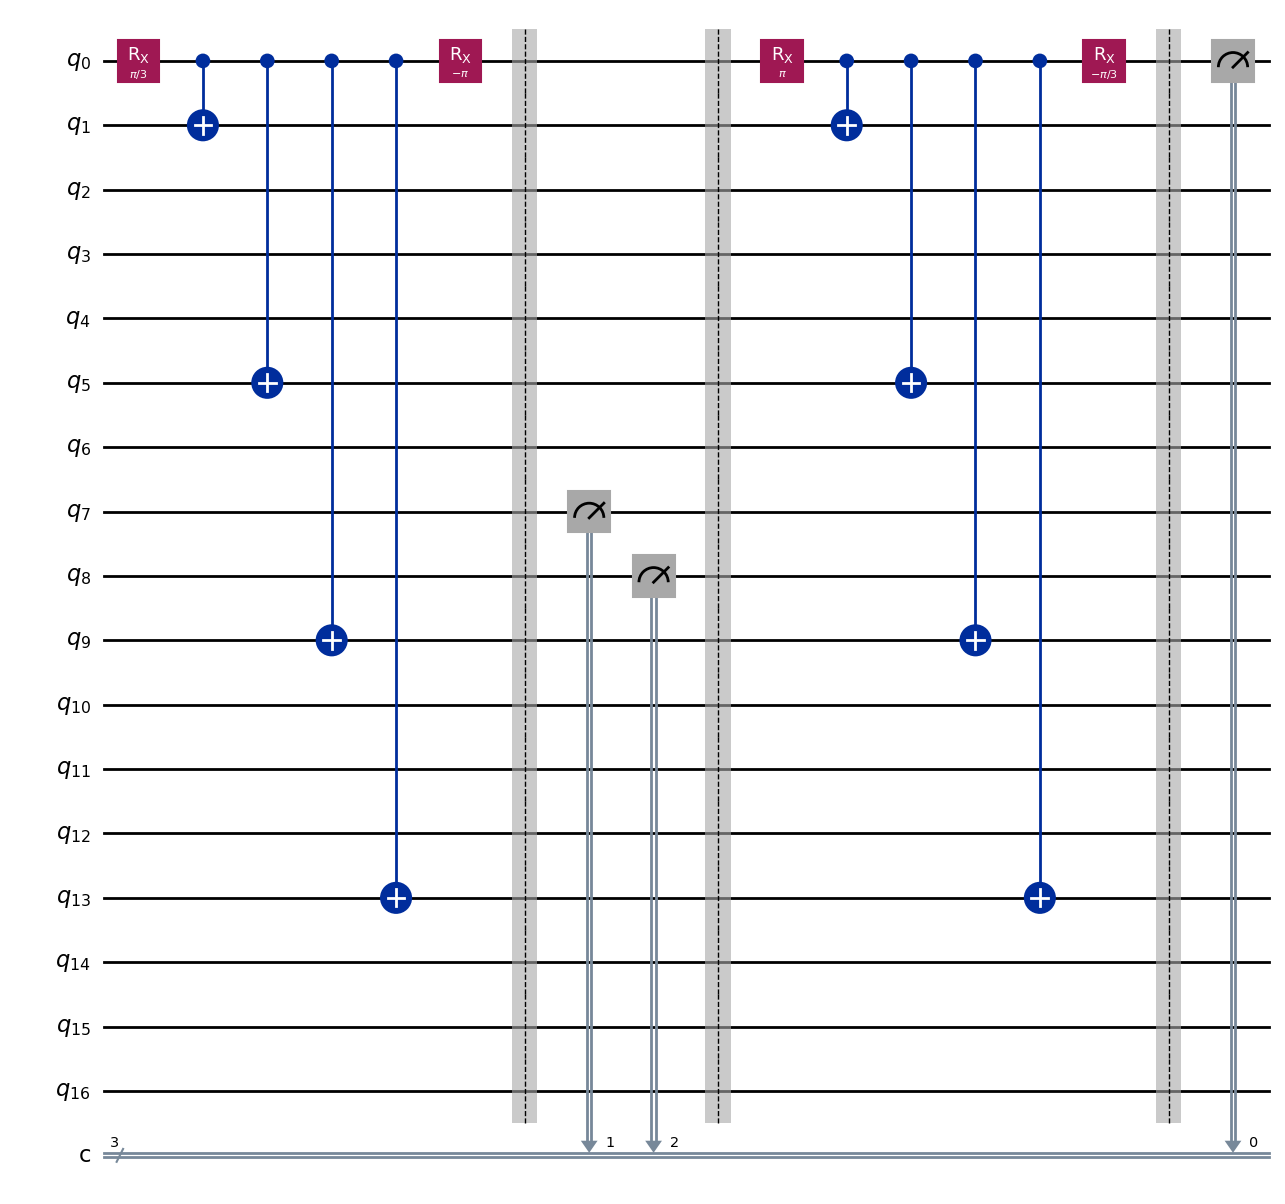

In [11]:
# We write our code in terms of N, so that it's scalable
N = 4
# The number of classical bits corresponds to how many bombs/ships.
num_ships = 2 # Assuming we have a ship at (2, C) and (2, D)
# The + 1 is for measuring q_0
qc = QuantumCircuit(N ** 2 + 1 , num_ships + 1)

qc.rx(np.pi / 3, 0)
# Since we are traveling through column A, we put our control gates there
for i in range(1, N ** 2, 4):
  qc.cx(0, i)

qc.rx(-np.pi, 0)

qc.barrier()

# Since there is a ship at q_7 and q_8, we represent them as measurements, which is why
# we measure them here.
qc.measure(7, 1)
qc.measure(8, 2)

qc.barrier()

qc.rx(np.pi, 0)
for i in range(1, N ** 2, 4):
  qc.cx(0, i)

qc.rx(-np.pi / 3, 0)

qc.barrier()

qc.measure(0, 0)
qc.draw("mpl")

In [12]:
# Now we simulate the process
# Create the simulator and transpiler
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)

# Simulating the circuit
sim_result = simulator.run(compiled_circuit).result()
counts = sim_result.get_counts()
print(f'Measurement counts: {counts}')

Measurement counts: {'000': 1024}


In [13]:
# This method finds all bit strings where it indicates there was an explosion
def valid_bitstrings(n):
    valid = []
    for i in range(2**n):
        bits = f"{i:0{n}b}"
        # Check if at least one of the first n-1 bits is 1
        if '1' in bits[:-1]:
            valid.append(bits)
    return valid

Similar to before, if $q_7$ or $q_8$ is measure as $1$, that means the bomb exploded. Otherwise, the bomb did not explode. If $q_0 = 1$, the bomb was found, and if $q_0 = 0$, that means no bomb occured and $q_0$ followed through its original path.

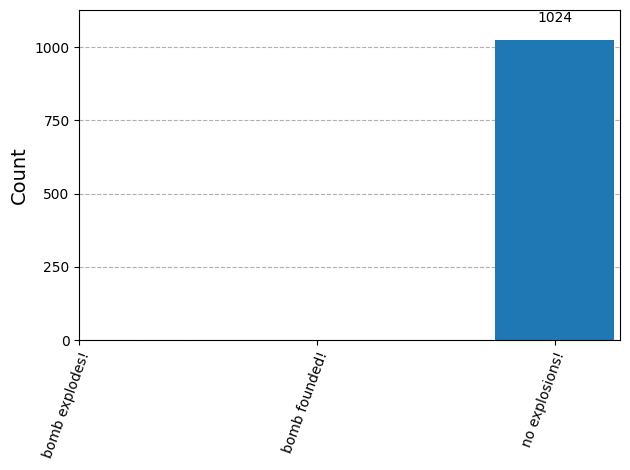

In [14]:
hist_data = {}
hist_data["bomb explodes!"] = 0
exploding_bits = valid_bitstrings(3)
for bit in exploding_bits:
  hist_data["bomb explodes!"] += counts.get(bit,0)
hist_data["no explosions!"] = counts.get("000", 0)
hist_data["bomb founded!"] = counts.get("001", 0)
plot_histogram(hist_data)

#### Remarks 6 - Commenting on Result
This is consistent with what we expected. If we checked along column A, there would've not been any ships. Let's try checking column C and see if our circuit would detect a bomb there.

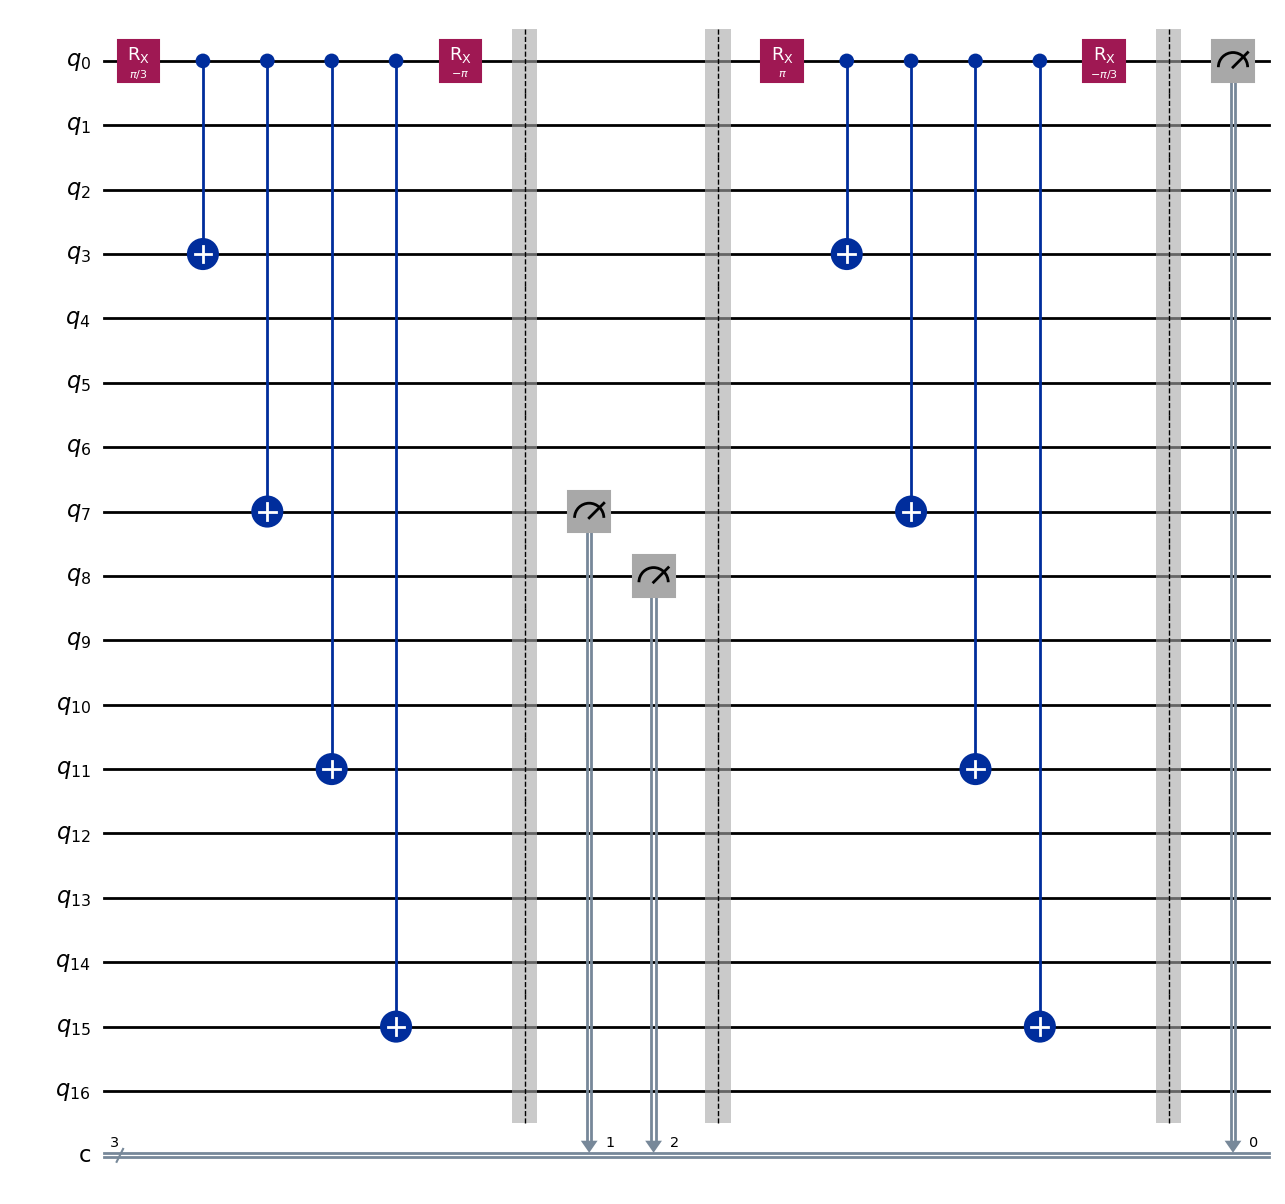

In [15]:
N = 4
# The number of classical bits corresponds to how many bombs/ships.
num_ships = 2 # Assuming we have a ship at (2, C) and (2, D)
# The + 1 is for measuring q_0
qc = QuantumCircuit(N ** 2 + 1 , num_ships + 1)

qc.rx(np.pi / 3, 0)
# Since we are traveling through column C, we put our control gates there
for i in range(N - 1, N ** 2, 4):
  qc.cx(0, i)

qc.rx(-np.pi, 0)

qc.barrier()

# Since there is a ship at q_7 and q_8, we represent them as measurements, which is why
# we measure them here.
qc.measure(7, 1)
qc.measure(8, 2)

qc.barrier()

qc.rx(np.pi, 0)
for i in range(N - 1, N ** 2, N):
  qc.cx(0, i)

qc.rx(-np.pi / 3, 0)

qc.barrier()

qc.measure(0, 0)
qc.draw("mpl")

In [16]:
# Now we simulate the process
# Create the simulator and transpiler
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)

# Simulating the circuit
sim_result = simulator.run(compiled_circuit, shots = 10000).result()
counts = sim_result.get_counts()
print(f'Measurement counts: {counts}')

Measurement counts: {'011': 1865, '001': 1817, '010': 594, '000': 5724}


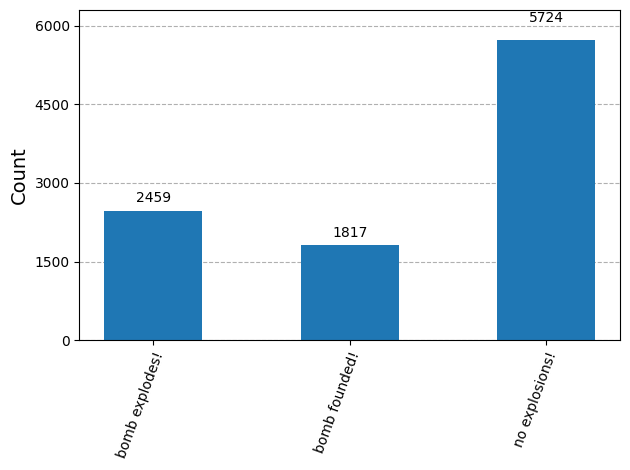

In [17]:
hist_data = {}
hist_data["bomb explodes!"] = 0
exploding_bits = valid_bitstrings(3)
for bit in exploding_bits:
  hist_data["bomb explodes!"] += counts.get(bit,0)
hist_data["no explosions!"] = counts.get("000", 0)
hist_data["bomb founded!"] = counts.get("001", 0)
plot_histogram(hist_data)

The above is consistent with our result, and we now have a ($\approx 20 \%$) probability of finding the bomb with causing an explosion!

</br>
We repeat this process for row $2$.

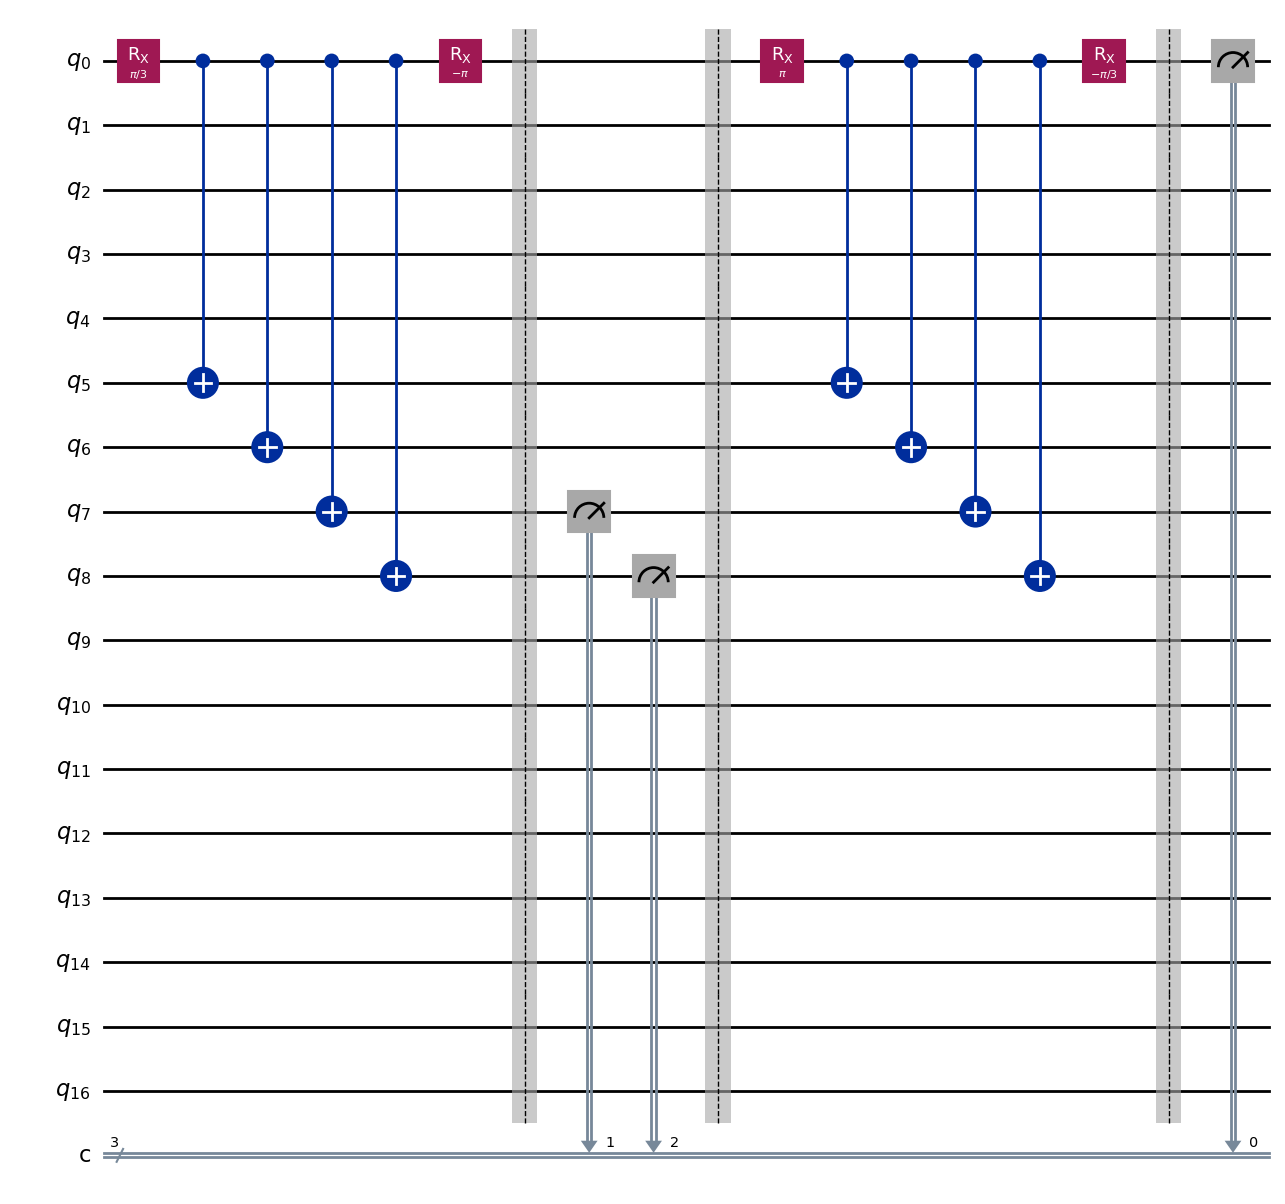

In [18]:
N = 4
# The number of classical bits corresponds to how many bombs/ships.
num_ships = 2 # Assuming we have a ship at (2, C) and (2, D)
# The + 1 is for measuring q_0
qc = QuantumCircuit(N ** 2 + 1 , num_ships + 1)

qc.rx(np.pi / 3, 0)
# Since we are traveling through column C, we put our control gates there
for i in range(N + 1, 2 * N + 1, 1):
  qc.cx(0, i)

qc.rx(-np.pi, 0)

qc.barrier()

# Since there is a ship at q_7 and q_8, we represent them as measurements, which is why
# we measure them here.
qc.measure(7, 1)
qc.measure(8, 2)

qc.barrier()

qc.rx(np.pi, 0)
for i in range(N + 1, 2 * N + 1, 1):
  qc.cx(0, i)

qc.rx(-np.pi / 3, 0)

qc.barrier()

qc.measure(0, 0)
qc.draw("mpl")

In [19]:
# Now we simulate the process
# Create the simulator and transpiler
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)

# Simulating the circuit
sim_result = simulator.run(compiled_circuit, shots = 10000).result()
counts = sim_result.get_counts()
print(f'Measurement counts: {counts}')

Measurement counts: {'001': 1854, '110': 616, '000': 5703, '111': 1827}


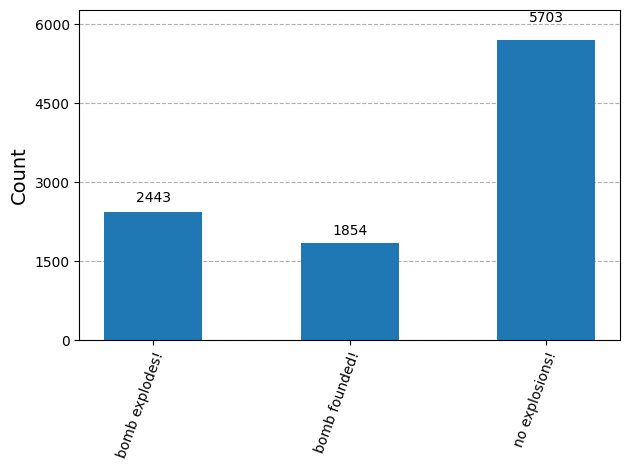

In [20]:
hist_data = {}
hist_data["bomb explodes!"] = 0
exploding_bits = valid_bitstrings(3)
for bit in exploding_bits:
  hist_data["bomb explodes!"] += counts.get(bit, 0)
hist_data["no explosions!"] = counts.get("000", 0)
hist_data["bomb founded!"] = counts.get("001", 0)
plot_histogram(hist_data)

Great! We also get about $20\%$ of detecting a bomb, meaning we are fairly confident that there a bomb in row $2$.

#### Remarks 7 - Applying the Quantum Zeno Effect

Previously, we demonstrated how we can use the Quantum Zeno Effect for one specific bomb, and so a question that may arise in whether or not we can use this technique as well on the Battleship game.

</br>

The answer to this is unfortunately likely **not possible** as recall that the Quantum Zeno Effect occurs by repeatedly visiting **one specific quantum system**. However, in this Battleship application, we are visiting and entangling $q_0$ to multiple ships and thus multiple quantum systems. Therefore, it is unlikely we can implement this effect into our circuit.

## Implementing the Battleship Into a Game! Version $1$

For this first version, it will work very simply. The user will give an input value of $N$, and a row and column value for where they will place one ship. And then the quantum algorithm will try to find where the user placed this ship.

</br>

Although this isn't necessary an "interactive" game, but this helps illustrate the power of the quantumn computing in finding where the ship is without $O(N^2)$ time.

**Give your inputs here!**

In [21]:
print("Enter the length of you would like the grid to be! Do something between 3 and 5 inclusive please.")
N = int(input())
if N > 5 or N < 3:
  raise ValueError("N should be between 4 and 10!")
print(f"Grid length: {N}")
print(f"Now enter which row (1 to {N}) you want to put the ship.")
row = int(input())
if row > N or row < 1:
  raise ValueError("row should be between 1 and N inclusive!")
print(f"Ship row location: {row}")
print(f"Now enter which column (1 to {N}) you want to put the ship.")
col = int(input())
if col > N or col < 1:
  raise ValueError("col should be between 1 and N inclusive!")
print(f"Ship column location: {col}")
print(f"Location of the ship => {(row, col)}")


Enter the length of you would like the grid to be! Do something between 3 and 5 inclusive please.
4
Grid length: N
Now enter which row (1 to 4) you want to put the ship.
3
Ship row location: 3
Now enter which column (1 to 4) you want to put the ship.
4
Ship column location: 4
Location of the ship => (3, 4)


**Now run this cell below to see the quantum circuit find which row your ship is at!**

Checking the grid row 1


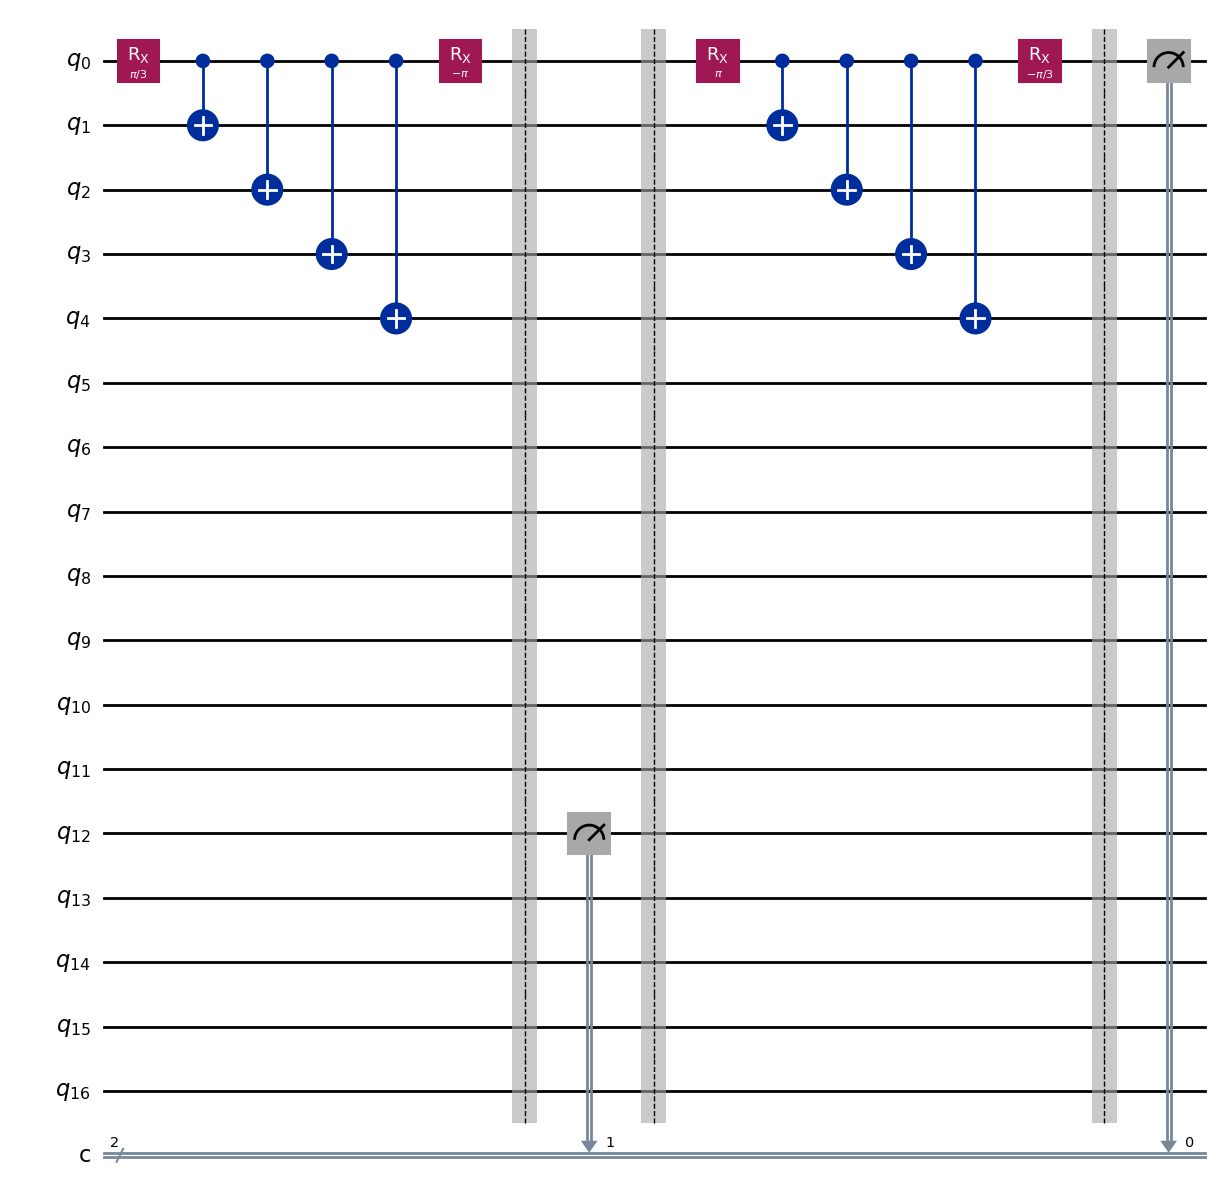

Measurement counts for 1: {'00': 10000}
Checking the grid row 2


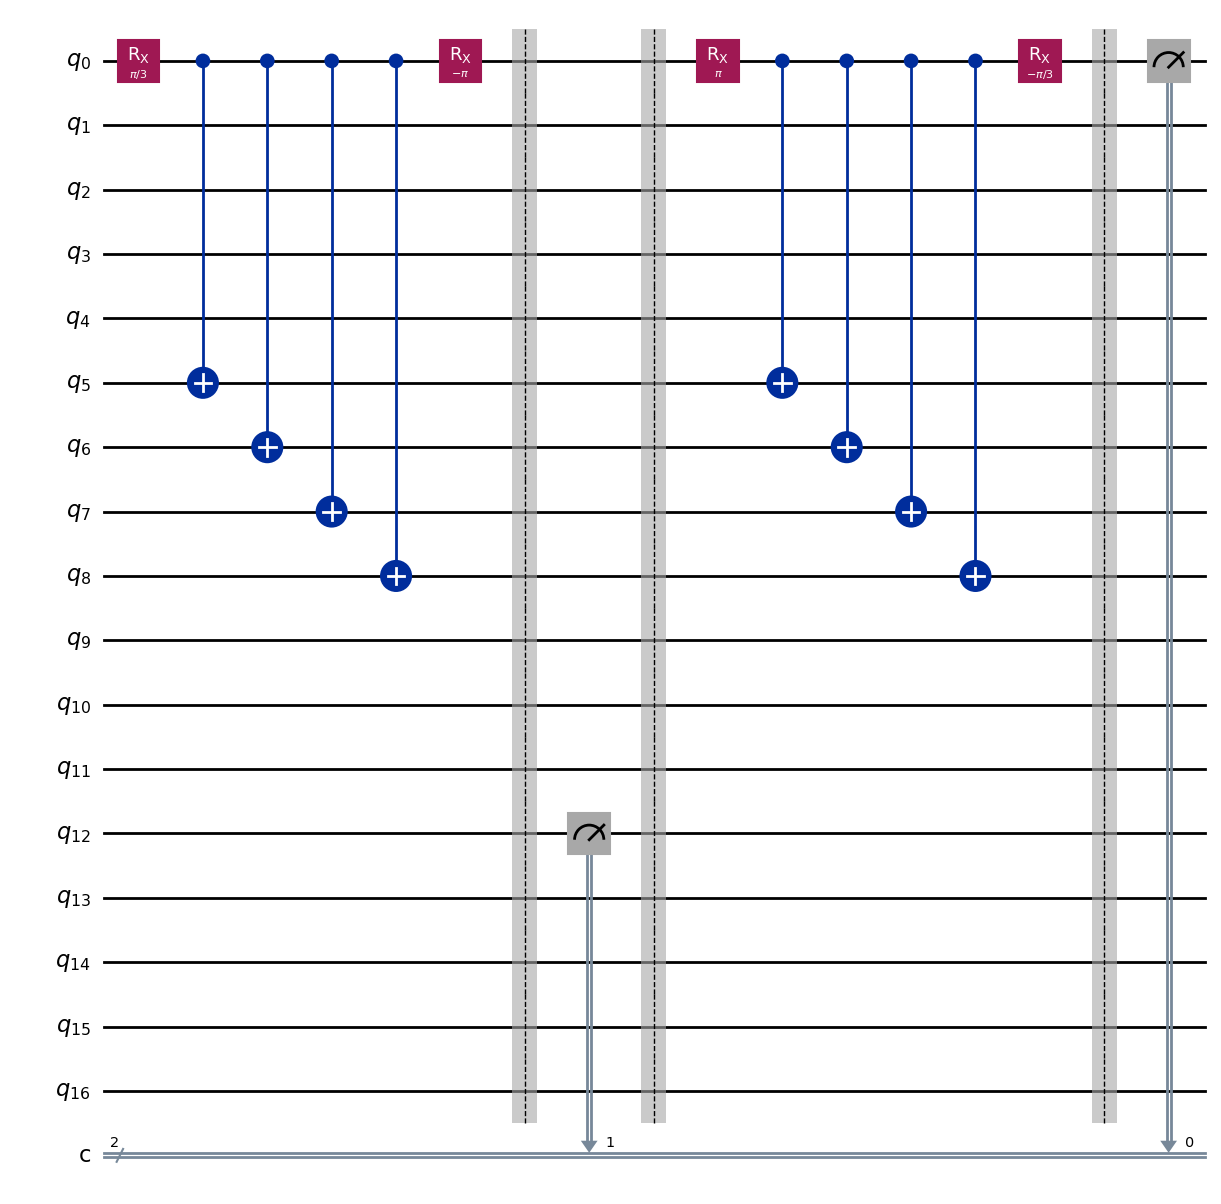

Measurement counts for 2: {'00': 10000}
Checking the grid row 3


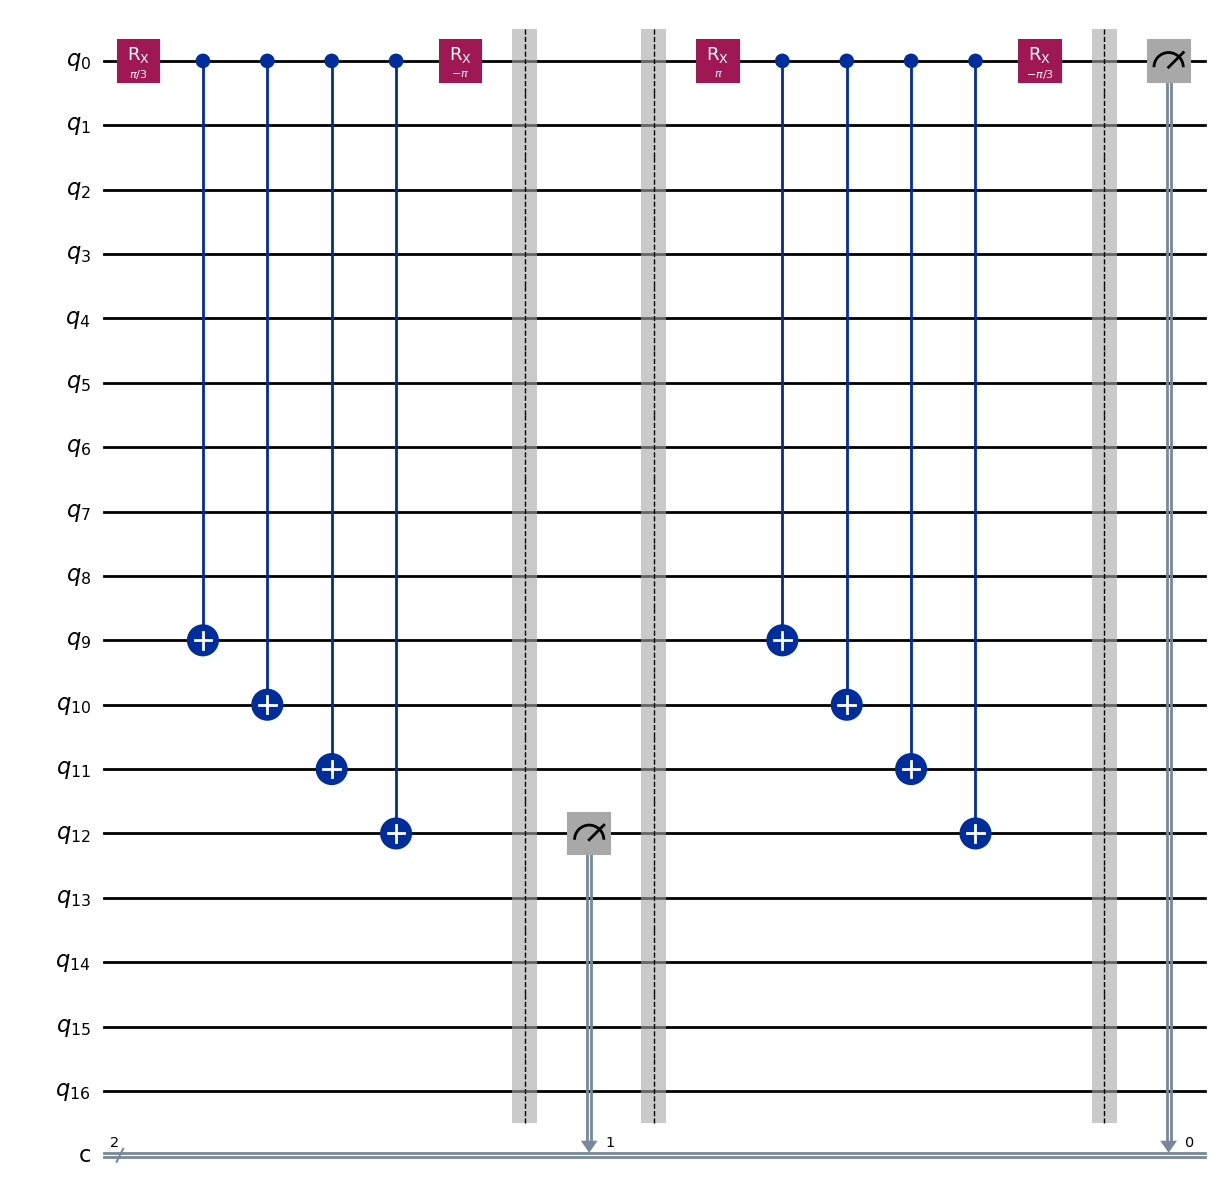

Measurement counts for 3: {'11': 1930, '01': 1803, '10': 601, '00': 5666}
Found row where the ship is: row 3. Breaking out of the loop


In [22]:
def checkRow(N: int, row: int, col: int, rowNum: int) -> bool:
  "Check if the current row contains the ship"
  # 2 classical bits for measuring
  qc = QuantumCircuit(N ** 2 + 1, 2)

  qc.rx(np.pi / 3, 0)

  for i in range(rowNum * N + 1, (rowNum + 1) * N + 1, 1):
    qc.cx(0, i)

  qc.rx(-np.pi, 0)

  bomb_coord = (row - 1) * N + col

  qc.barrier()

  qc.measure(bomb_coord, 1)

  qc.barrier()

  qc.rx(np.pi, 0)

  for i in range(rowNum * N + 1, (rowNum + 1) * N + 1, 1):
    qc.cx(0, i)

  qc.rx(-np.pi / 3, 0)

  qc.barrier()

  qc.measure(0, 0)
  simulator = AerSimulator()
  compiled_circuit = transpile(qc, simulator)
  display(qc.draw("mpl"))

  # Simulating the circuit
  sim_result = simulator.run(compiled_circuit, shots = 10000).result()
  counts = sim_result.get_counts()
  print(f'Measurement counts for {rowNum + 1}: {counts}')
  for count in counts:
    if count[-1:] == '1':
      return True
  return False
predictedRow = 0
for i in range(N):
  print(f"Checking the grid row {i + 1}")
  if checkRow(N, row, col, i):
    predictedRow = i + 1
    print(f"Found row where the ship is: row {predictedRow}. Breaking out of the loop")
    break


Checking the grid col 1


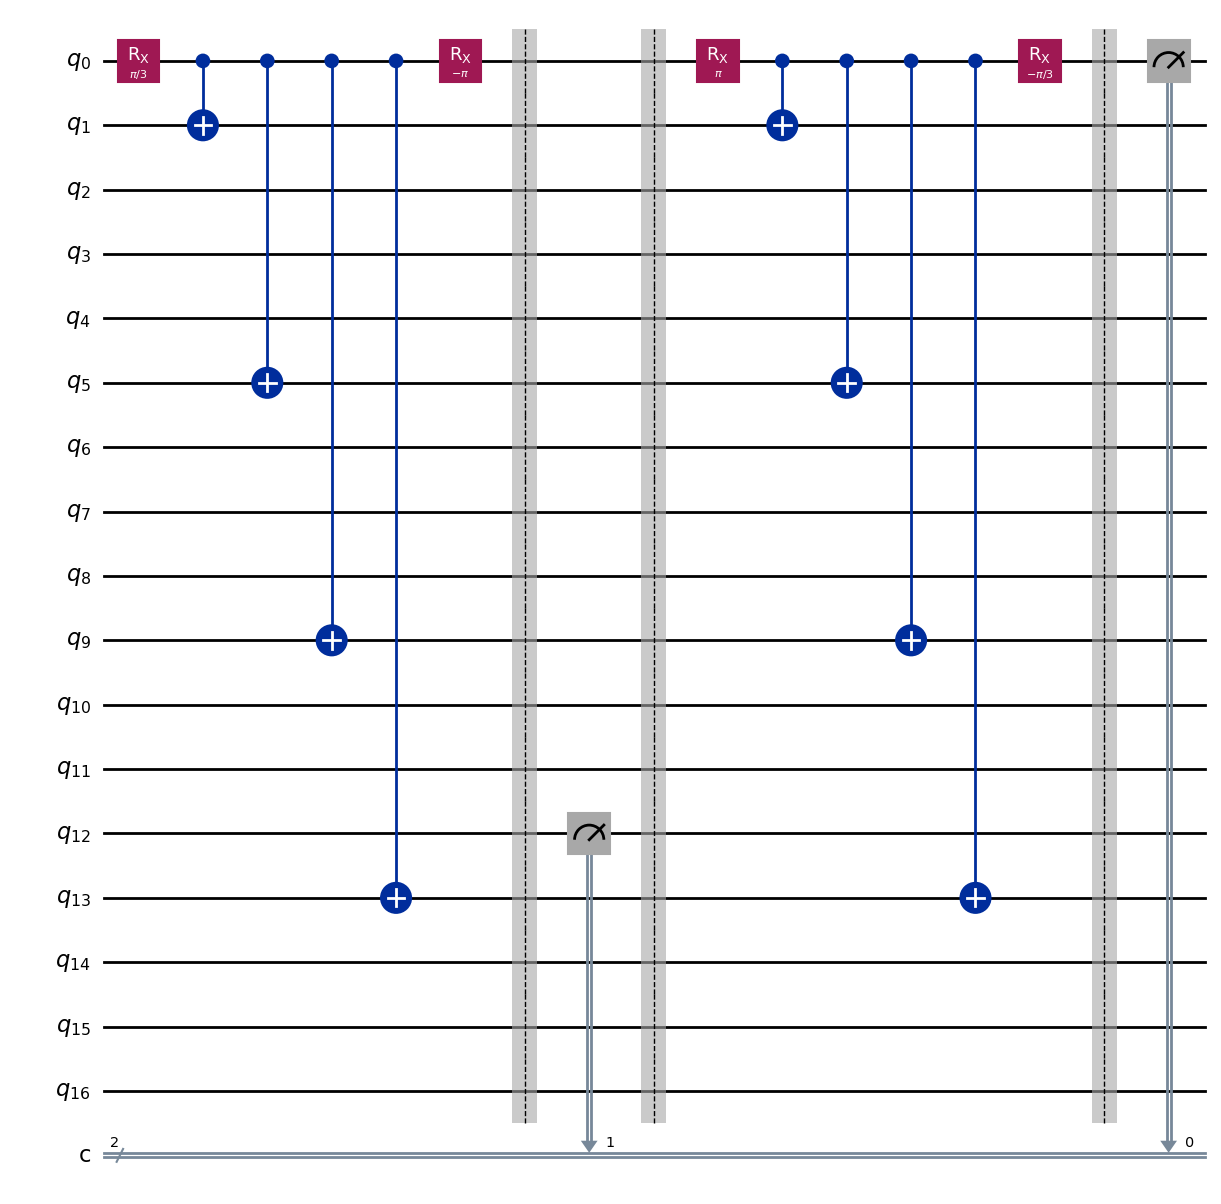

Measurement counts for 1: {'00': 10000}
Checking the grid col 2


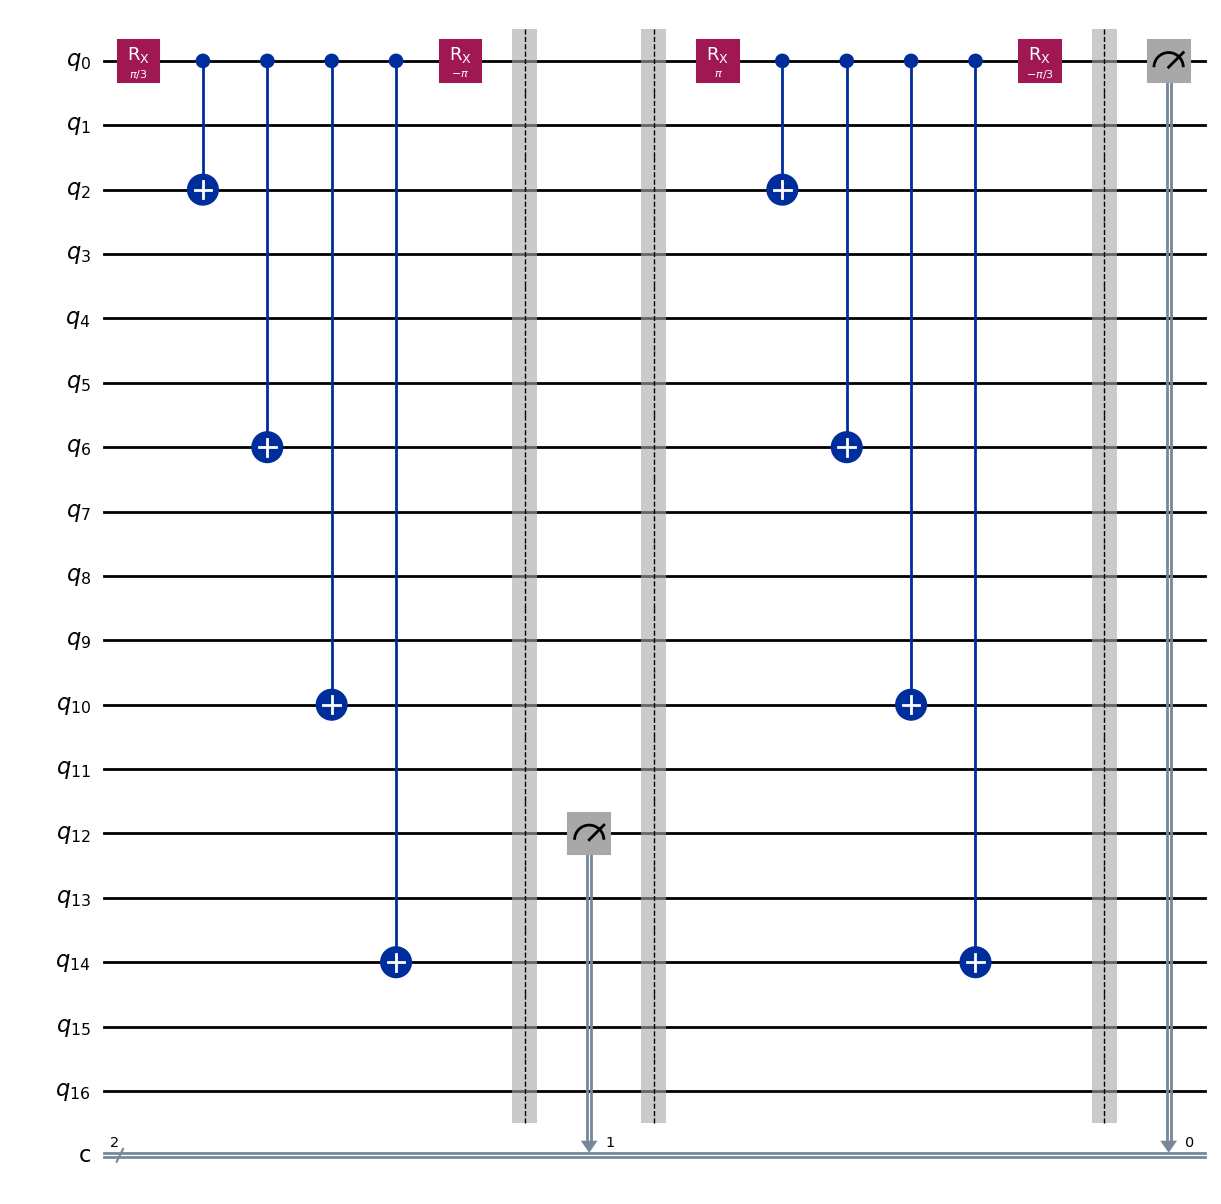

Measurement counts for 2: {'00': 10000}
Checking the grid col 3


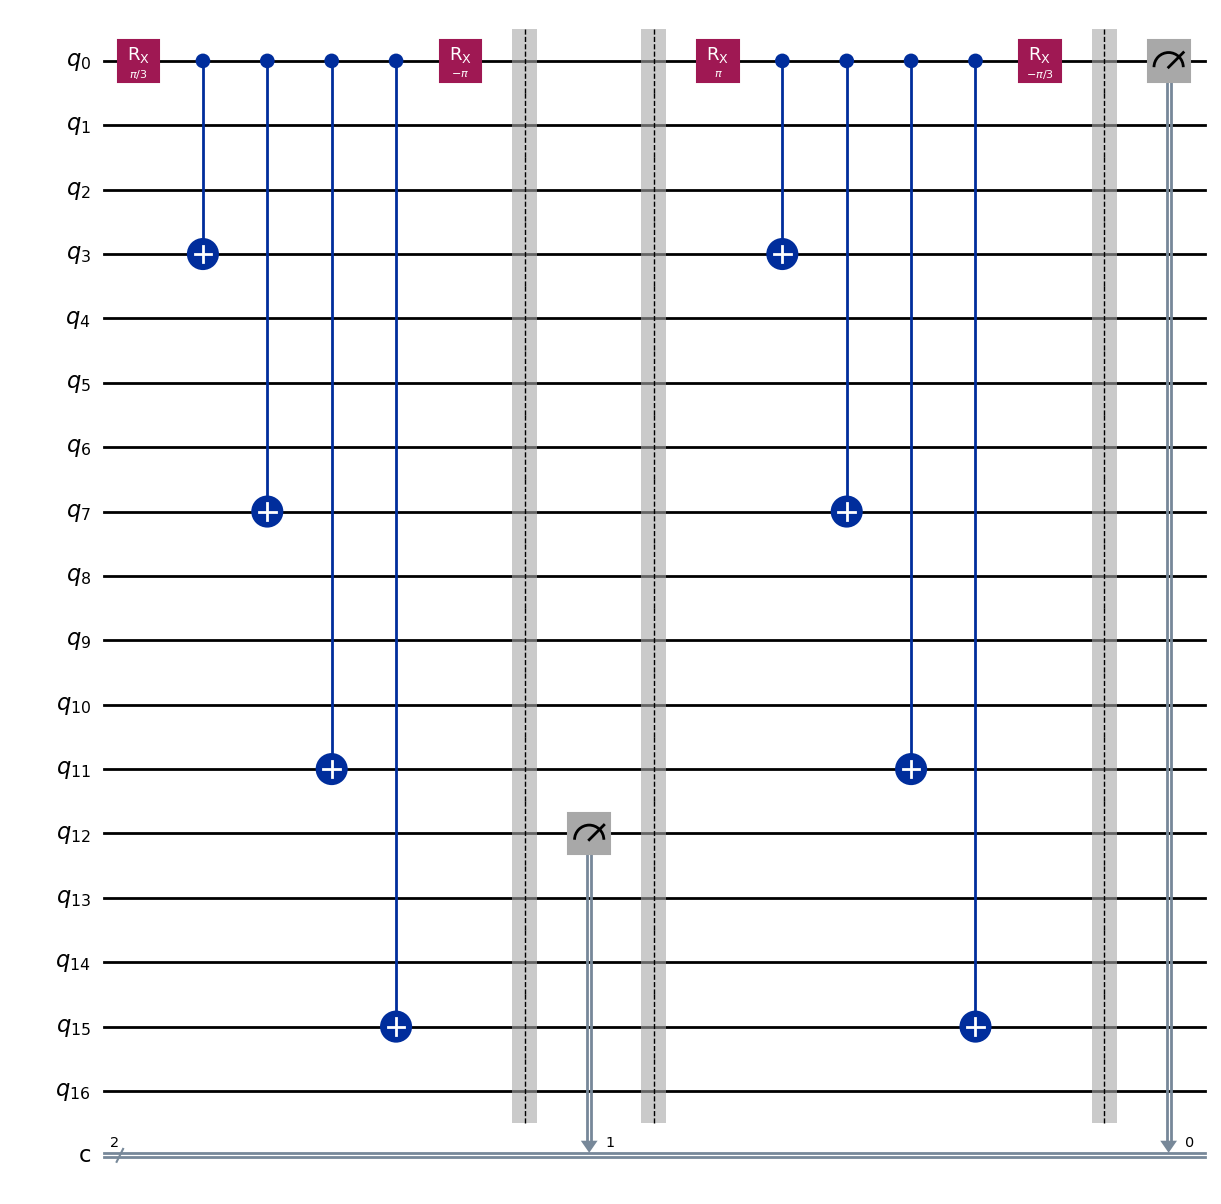

Measurement counts for 3: {'00': 10000}
Checking the grid col 4


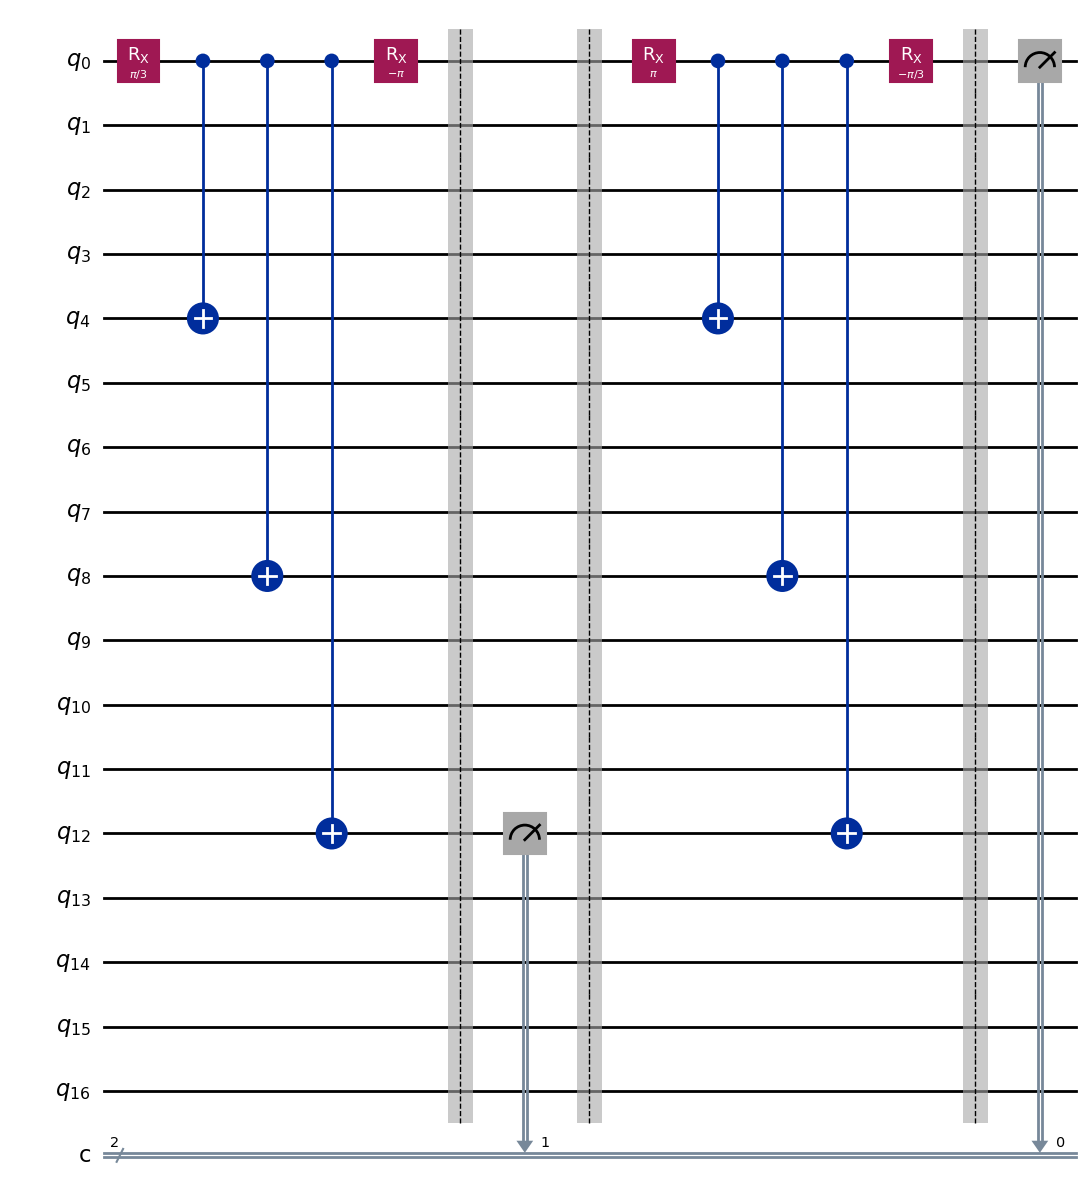

Measurement counts for 4: {'11': 1862, '00': 5581, '10': 634, '01': 1923}
Found column where the ship is: column 4. Breaking out of the loop


In [23]:
def checkCol(N: int, row: int, col: int, colNum: int) -> bool:
  "Check if the current column contains the ship"
  # 2 classical bits for measuring
  qc = QuantumCircuit(N ** 2 + 1, 2)

  qc.rx(np.pi / 3, 0)

  for i in range(colNum + 1, N ** 2, N):
    qc.cx(0, i)

  qc.rx(-np.pi, 0)

  bomb_coord = (row - 1) * N + col

  qc.barrier()

  qc.measure(bomb_coord, 1)

  qc.barrier()

  qc.rx(np.pi, 0)

  for i in range(colNum + 1, N ** 2, N):
    qc.cx(0, i)

  qc.rx(-np.pi / 3, 0)

  qc.barrier()

  qc.measure(0, 0)
  simulator = AerSimulator()
  compiled_circuit = transpile(qc, simulator)
  display(qc.draw("mpl"))

  # Simulating the circuit
  sim_result = simulator.run(compiled_circuit, shots = 10000).result()
  counts = sim_result.get_counts()
  print(f'Measurement counts for {colNum + 1}: {counts}')
  for count in counts:
    if count[-1:] == '1':
      return True
  return False
predictedCol = 0
for i in range(N):
  print(f"Checking the grid col {i + 1}")
  if checkCol(N, row, col, i):
    predictedCol = i + 1
    print(f"Found column where the ship is: column {predictedCol}. Breaking out of the loop")
    break


In [24]:
print(f"Inputted coordinates by user: {(row, col)}")
print(f"Predicted coordinates by quantum simulation: {(predictedRow, predictedCol)}")

Inputted coordinates by user: (3, 4)
Predicted coordinates by quantum simulation: (3, 4)


#### Remarks 8 - Commenting on the Efficency of the Algorithm
As shown above, if we are dealing with one ship only, our algorithm is more efficient than simply going through all the squares and checking if there was a ship. By using qubits, we only check each row and column. There are $N$ rows and $N$ columns, so our time complexity would've been $O(N + N) \to O(N)$.


However, note that if we were to expand this to more than one ship, then it gets more complicated. This is because, consider the following configuration:
$$
\begin{array}{|c|c|c|c|c|}
& A & B & C & D \\
\hline
1 & & & & \\
\hline
2 & & & X & \\
\hline
3 & & & & X\\
\hline
4 & & & & \\
\hline
\end{array}
$$

If we were to run the same algorithm, we get the following results:

**Run the Cells Below**

Checking the grid row 1


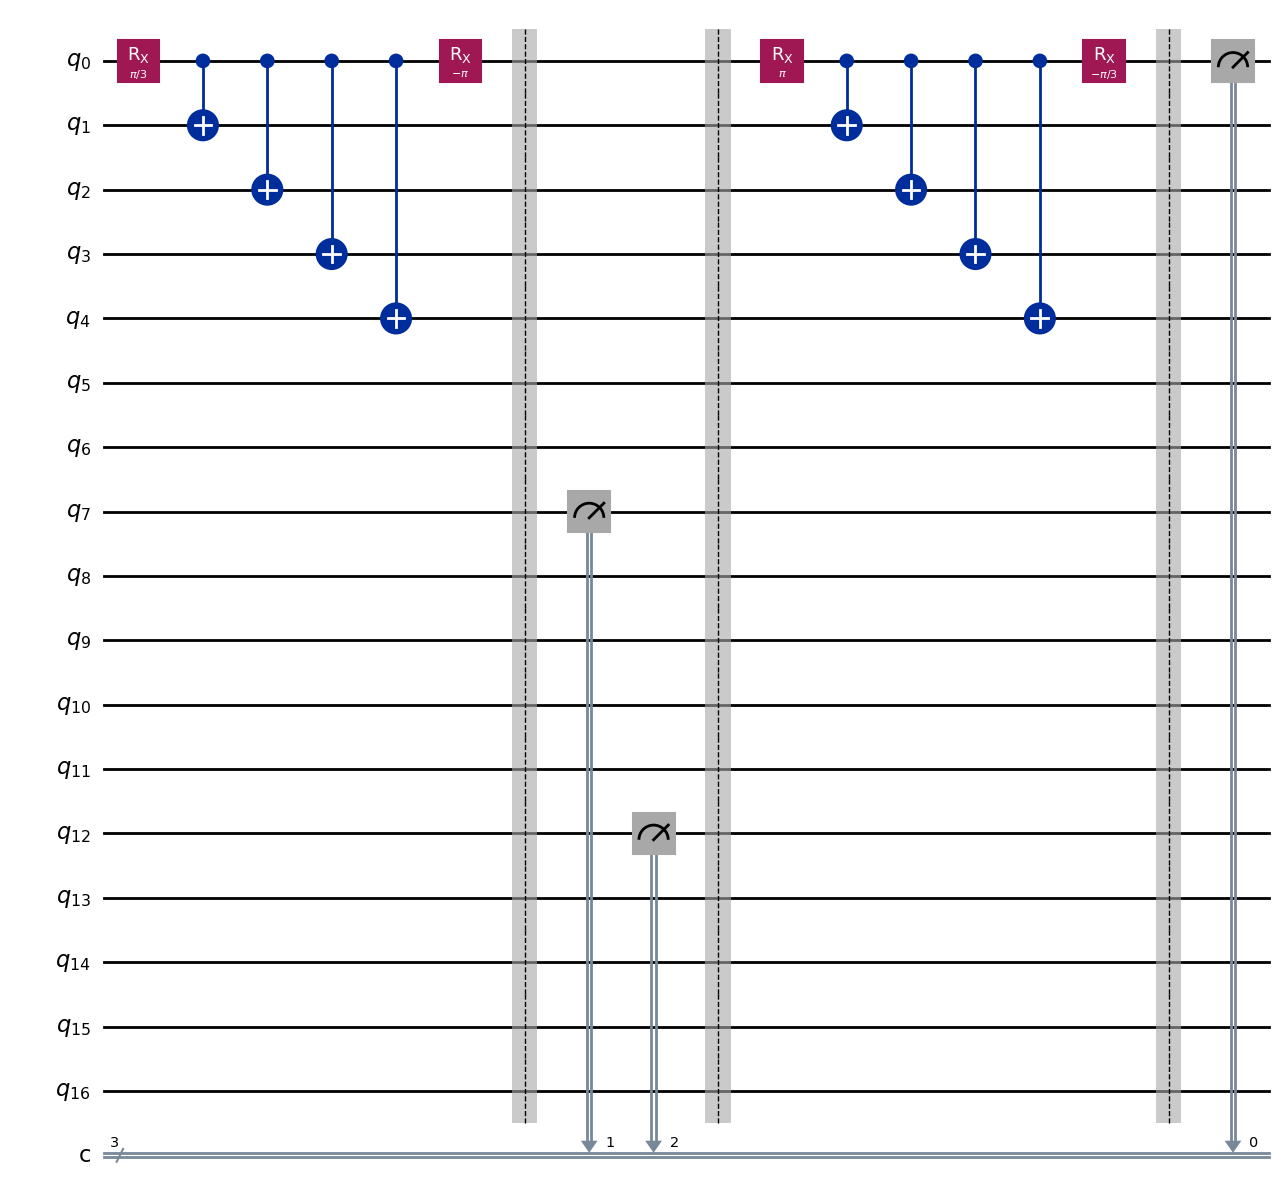

Measurement counts for 1: {'000': 10000}
Checking the grid row 2


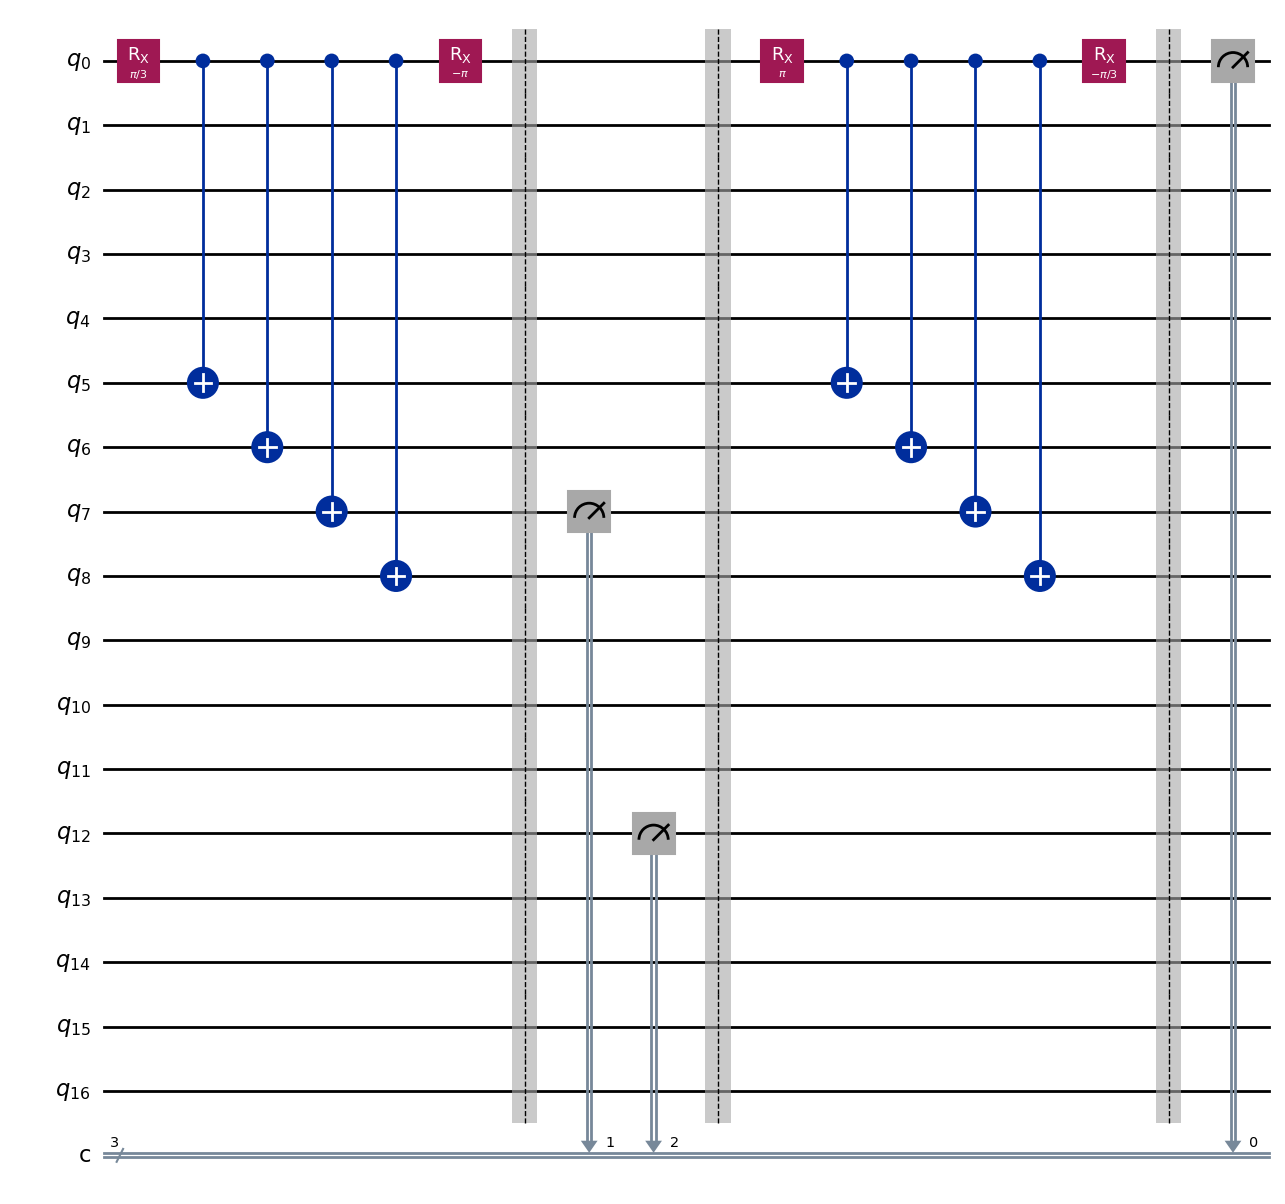

Measurement counts for 2: {'001': 1870, '011': 1868, '010': 607, '000': 5655}
Found row where the ship is: row 2.
Checking the grid row 3


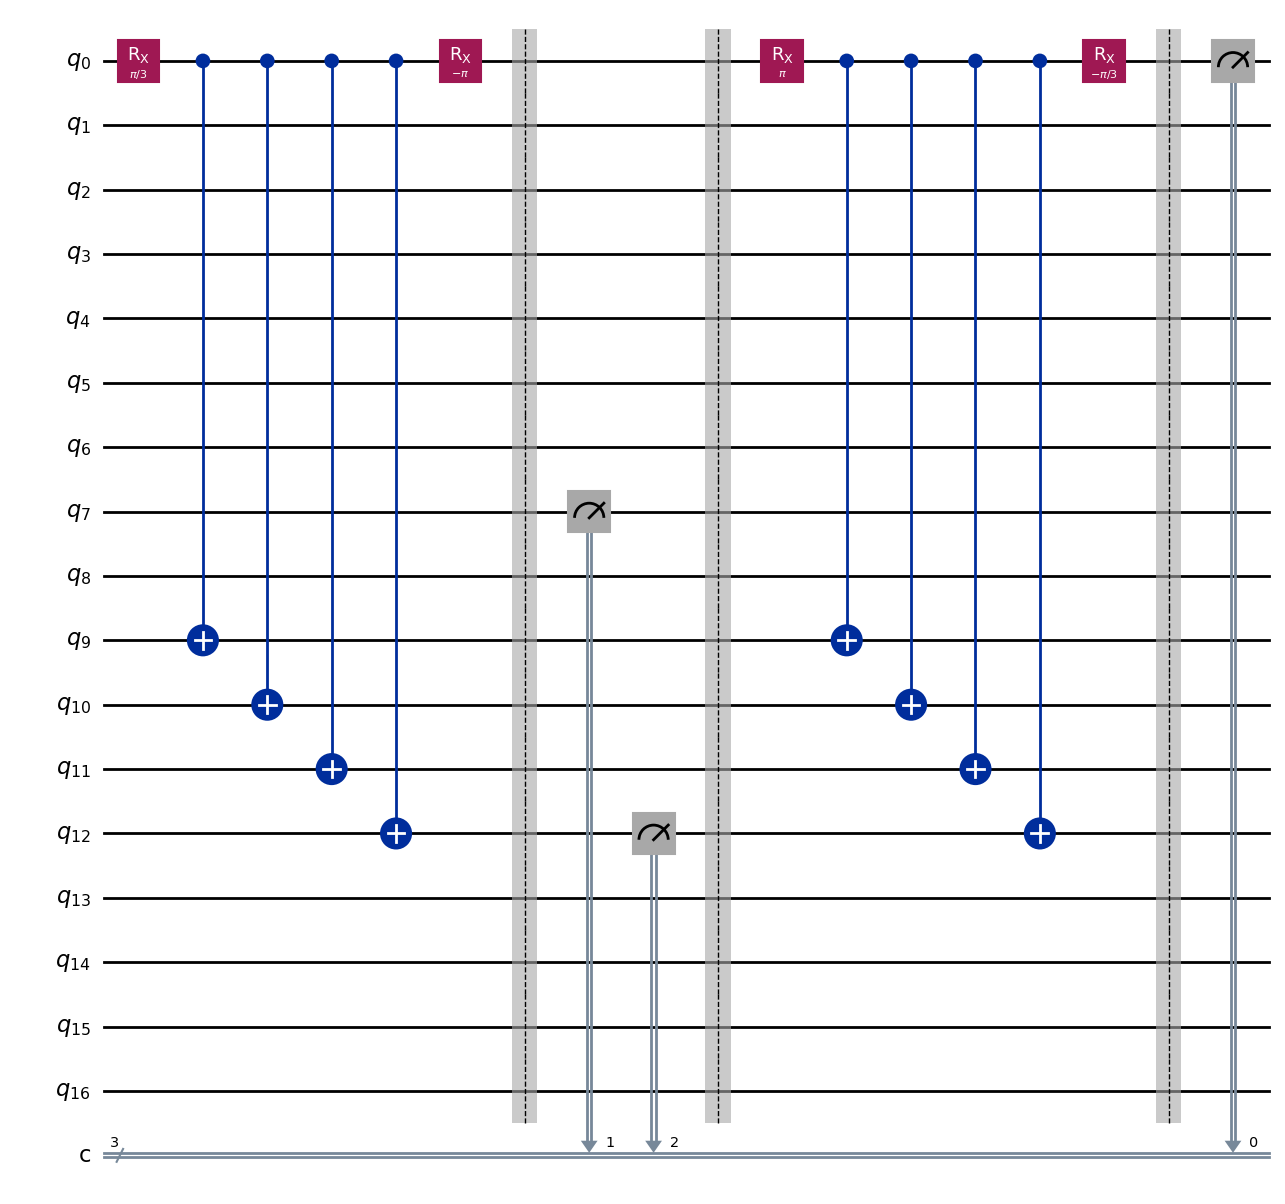

Measurement counts for 3: {'100': 604, '101': 1870, '001': 1875, '000': 5651}
Found row where the ship is: row 3.
Checking the grid row 4


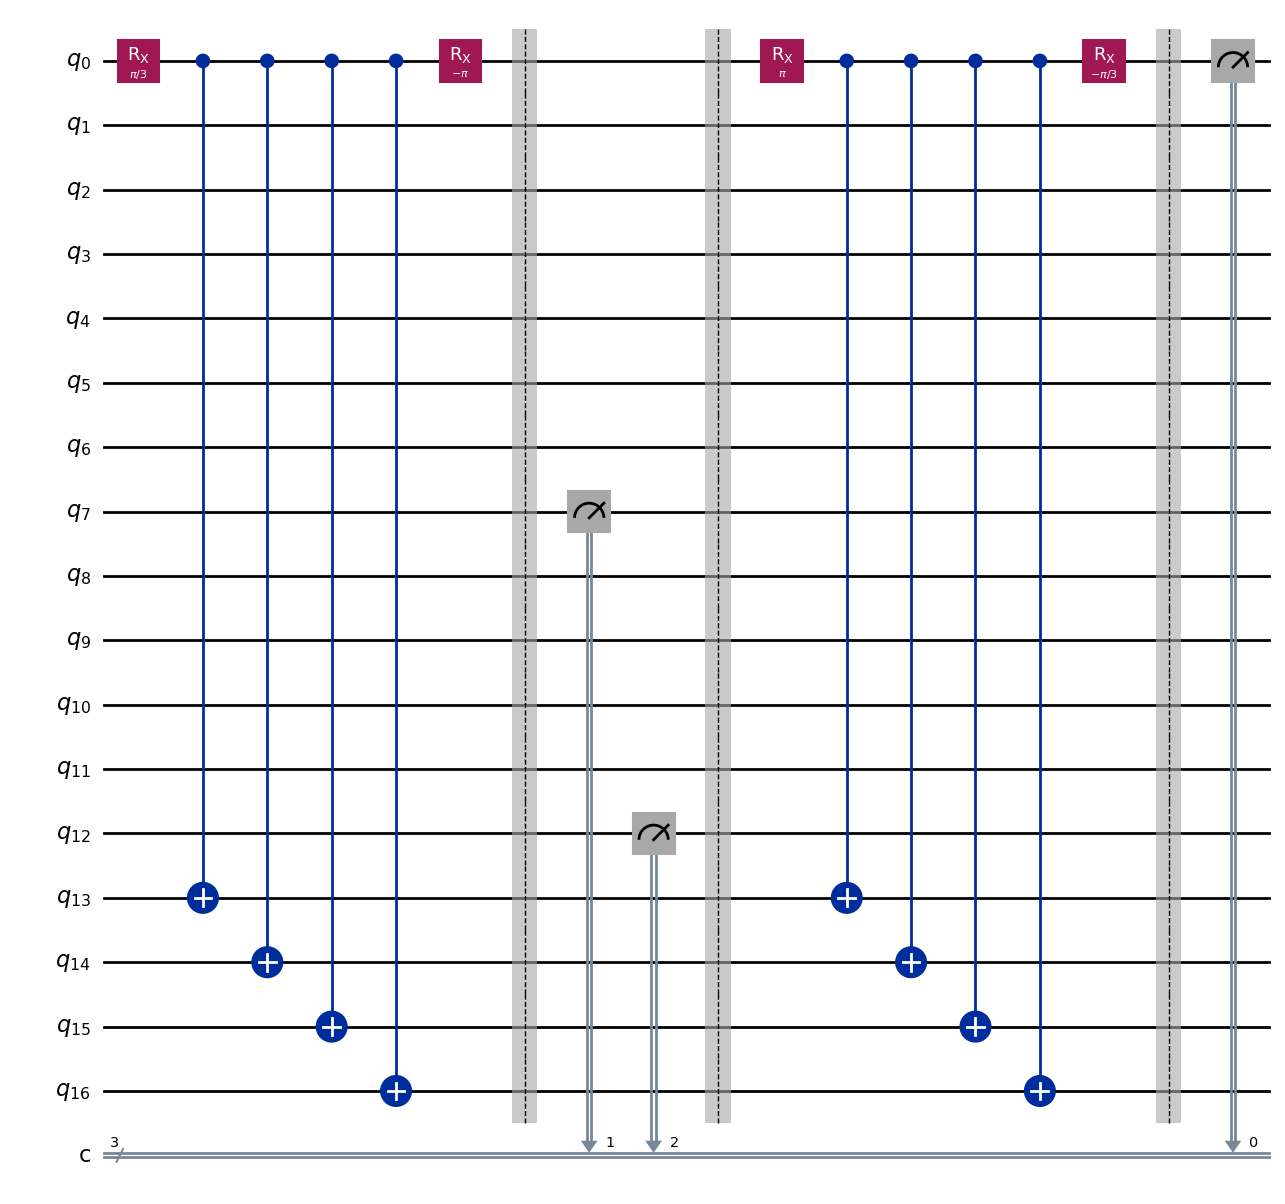

Measurement counts for 4: {'000': 10000}


In [25]:
N = 4
def checkRow(N: int, rowNum: int) -> bool:
  "Check if the current row contains the ship"
  # 2 classical bits for measuring
  qc = QuantumCircuit(N ** 2 + 1, 3)

  qc.rx(np.pi / 3, 0)

  for i in range(rowNum * N + 1, (rowNum + 1) * N + 1, 1):
    qc.cx(0, i)

  qc.rx(-np.pi, 0)

  qc.barrier()

  qc.measure(7, 1)
  qc.measure(12, 2)

  qc.barrier()

  qc.rx(np.pi, 0)

  for i in range(rowNum * N + 1, (rowNum + 1) * N + 1, 1):
    qc.cx(0, i)

  qc.rx(-np.pi / 3, 0)

  qc.barrier()

  qc.measure(0, 0)
  simulator = AerSimulator()
  compiled_circuit = transpile(qc, simulator)
  display(qc.draw("mpl"))
  # Simulating the circuit
  sim_result = simulator.run(compiled_circuit, shots = 10000).result()
  counts = sim_result.get_counts()
  print(f'Measurement counts for {rowNum + 1}: {counts}')
  for count in counts:
    if int(count) > 0:
      return True
  return False
pRow = []
predictedRow = 0
for i in range(N):
  print(f"Checking the grid row {i + 1}")
  if checkRow(N, i):
    predictedRow = i + 1
    pRow.append(predictedRow)
    print(f"Found row where the ship is: row {predictedRow}.")


Checking the grid col 1


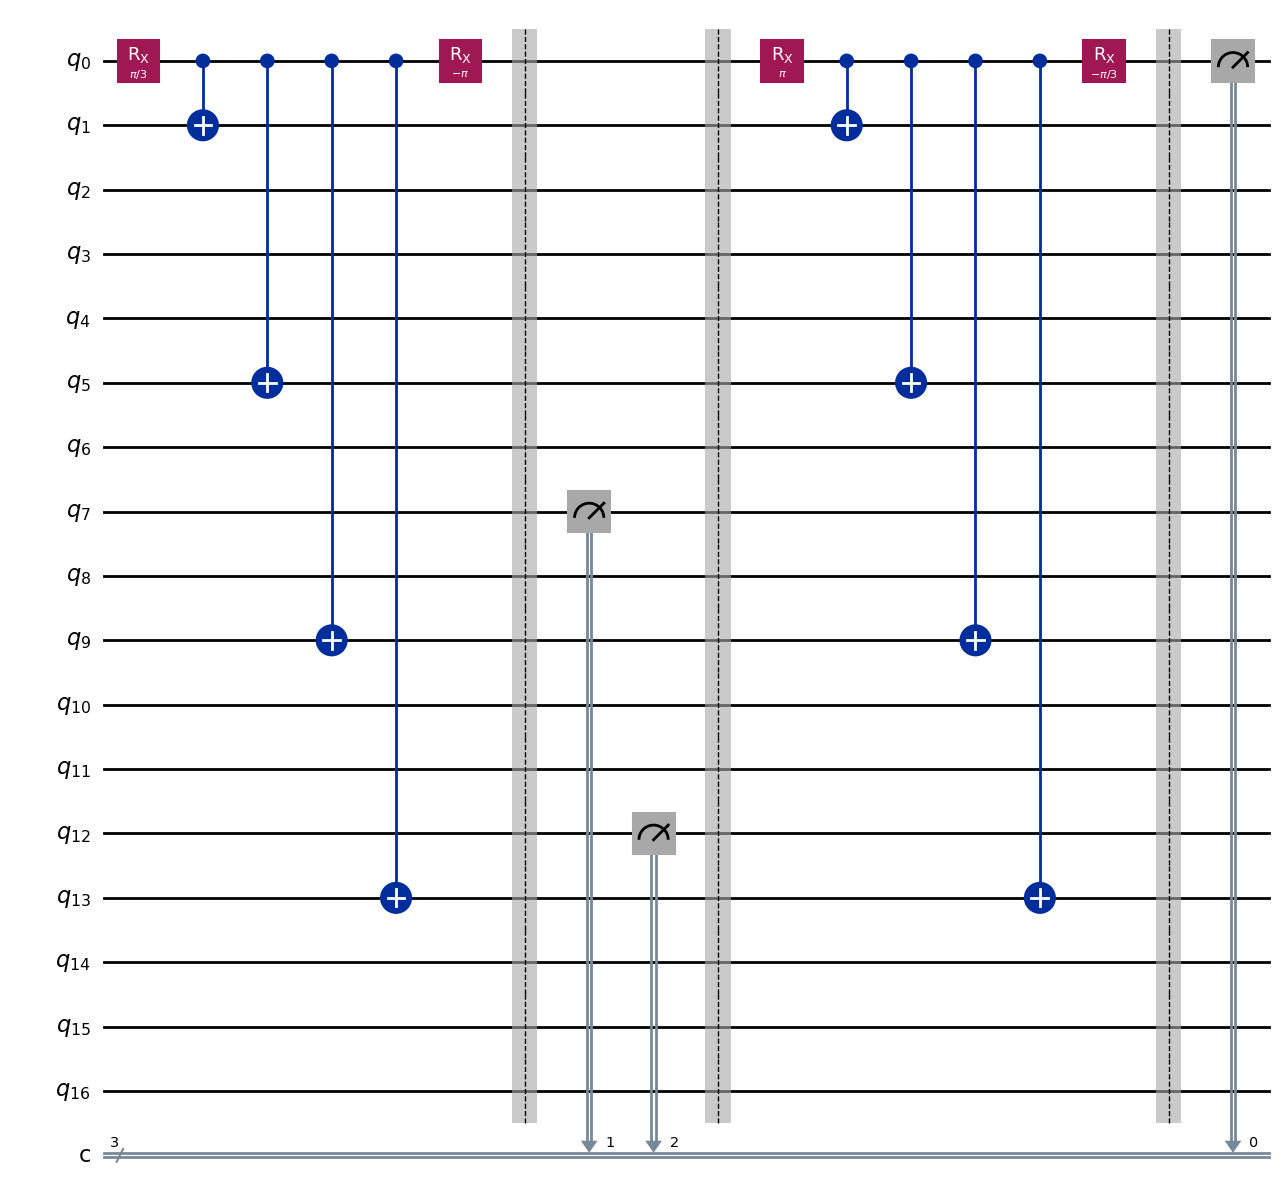

Measurement counts for 1: {'000': 10000}
Checking the grid col 2


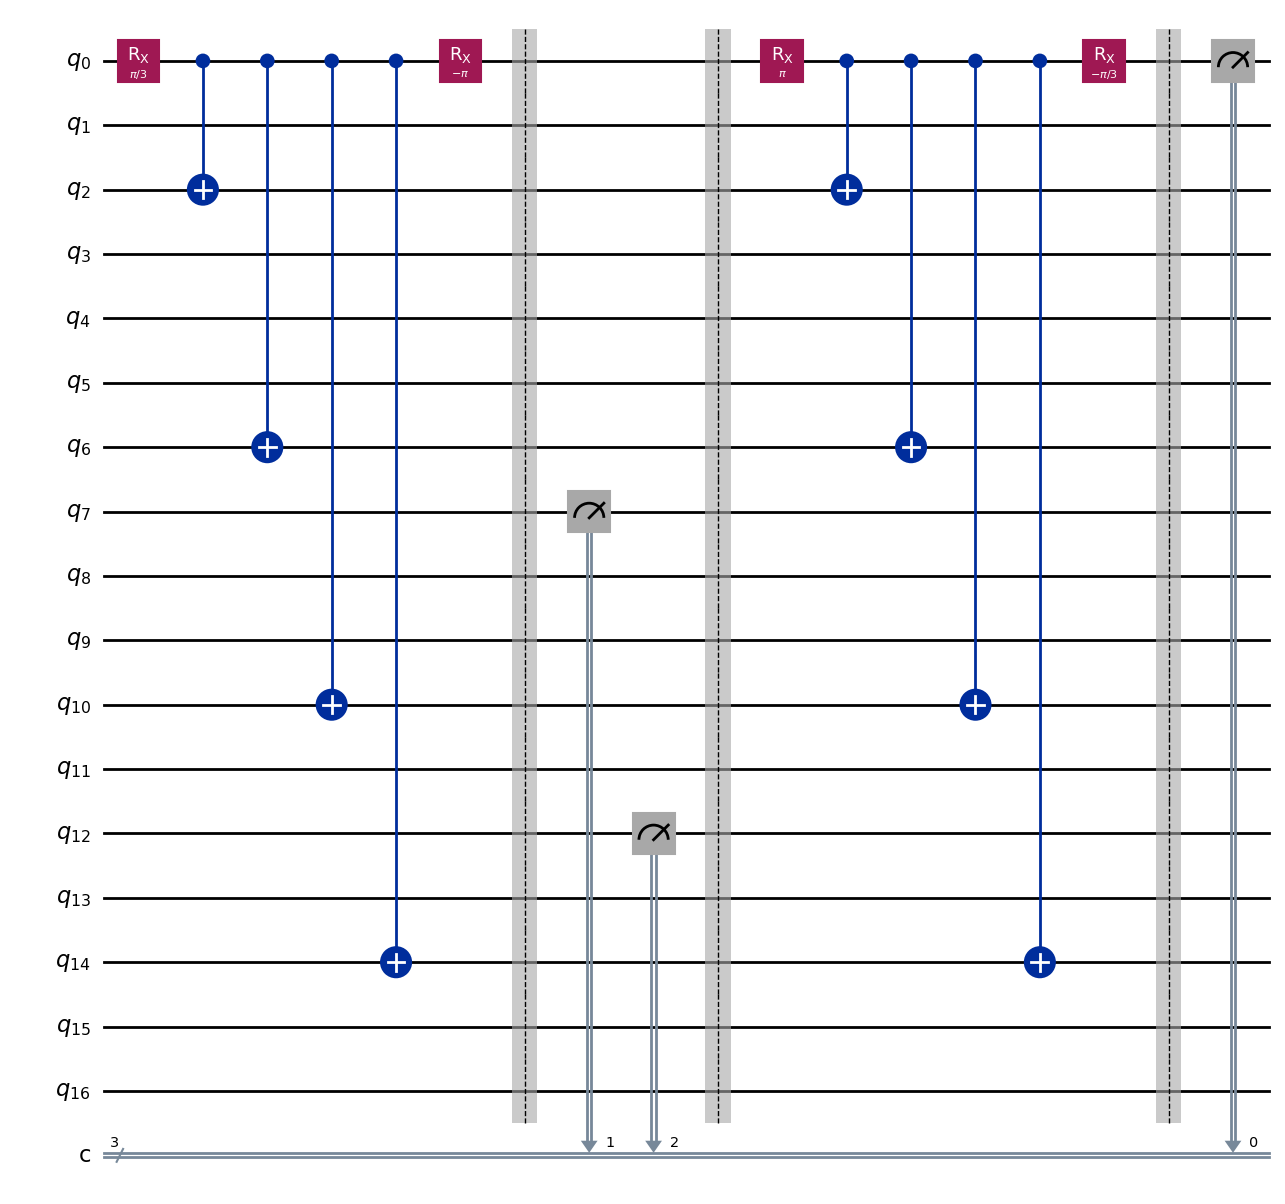

Measurement counts for 2: {'000': 10000}
Checking the grid col 3


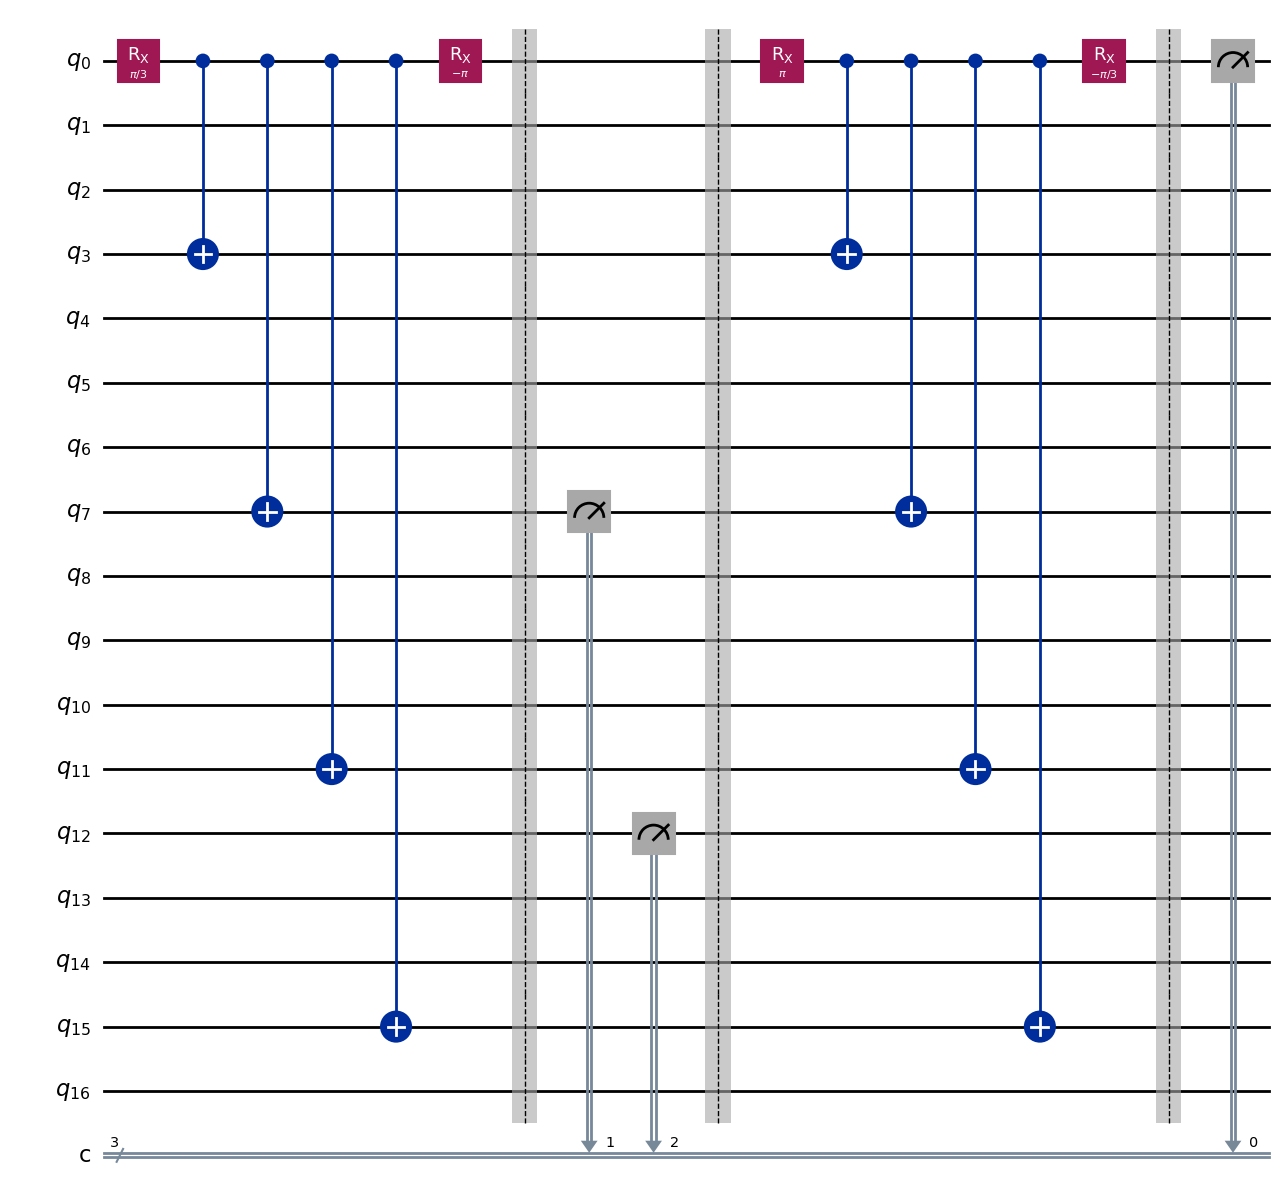

Measurement counts for 3: {'001': 1898, '011': 1879, '010': 643, '000': 5580}
Found column where the ship is: column 3.
Checking the grid col 4


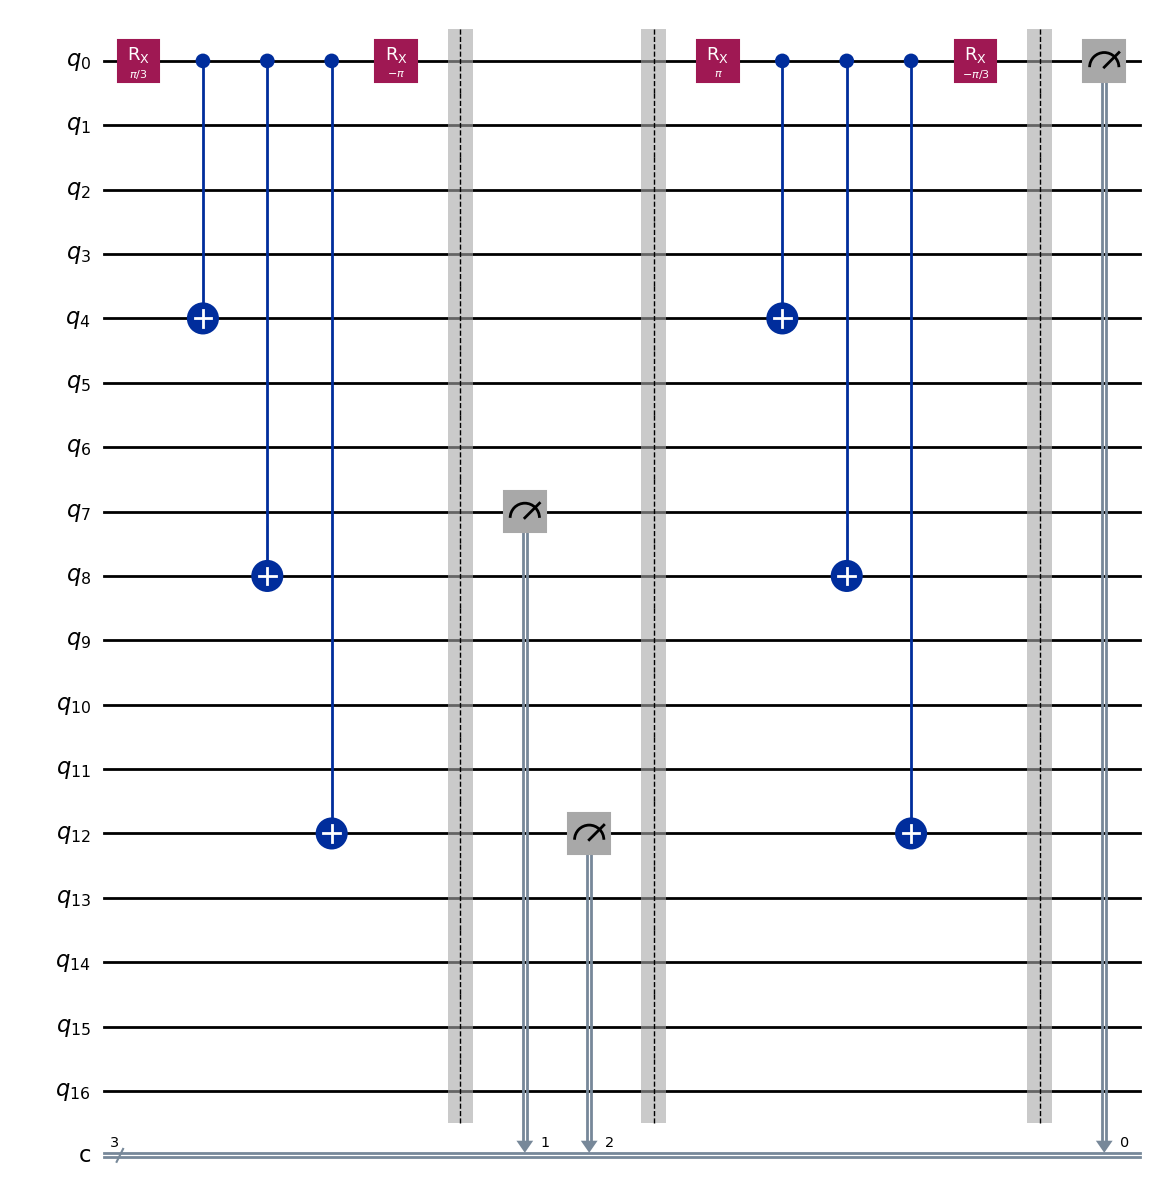

Measurement counts for 4: {'100': 600, '000': 5538, '101': 1910, '001': 1952}
Found column where the ship is: column 4.


In [26]:
def checkCol(N: int, colNum: int) -> bool:
  "Check if the current column contains the ship"
  # 2 classical bits for measuring
  qc = QuantumCircuit(N ** 2 + 1, 3)

  qc.rx(np.pi / 3, 0)

  for i in range(colNum + 1, N ** 2, N):
    qc.cx(0, i)

  qc.rx(-np.pi, 0)

  qc.barrier()

  qc.measure(7, 1)
  qc.measure(12, 2)

  qc.barrier()

  qc.rx(np.pi, 0)

  for i in range(colNum + 1, N ** 2, N):
    qc.cx(0, i)

  qc.rx(-np.pi / 3, 0)

  qc.barrier()

  qc.measure(0, 0)
  simulator = AerSimulator()
  compiled_circuit = transpile(qc, simulator)
  display(qc.draw("mpl"))
  # Simulating the circuit
  sim_result = simulator.run(compiled_circuit, shots = 10000).result()
  counts = sim_result.get_counts()
  print(f'Measurement counts for {colNum + 1}: {counts}')
  for count in counts:
    if int(count) > 0:
      return True
  return False
pCol = []
predictedCol = 0
for i in range(N):
  print(f"Checking the grid col {i + 1}")
  if checkCol(N, i):
    predictedCol = i + 1
    print(f"Found column where the ship is: column {predictedCol}.")
    pCol.append(predictedCol)


In [27]:
print("Potential Locations of the two ships:")
print("Combination 1:")
print((pRow[0], pCol[0]))
print((pRow[1], pCol[1]))

print("Combination 2:")
print((pRow[1], pCol[0]))
print((pRow[0], pCol[1]))

Potential Locations of the two ships:
Combination 1:
(2, 3)
(3, 4)
Combination 2:
(3, 3)
(2, 4)


As shown above, if we used our circuits in a similar fashion, we would get two different combinations. Thus, we wouldn't be able to get the right position!

## Making the Actual Battleship Game! Version $2$

We now use our information to turn the grid into a game, where each time the user can either predict that there is a ship or not in a specific row/column!

**Run this cell to create helper functions! The code cell below it is where the gameplay occurs!**

In [80]:
import random
import itertools
# Showing the instructions again :(
def showInstructions(N: int):
  print("The next time you see an input box, you will have 4 options:")
  print("OPTION 1: END THE GAME:")
  print("     This is done by entering the word 'END'. By doing so, you will see the grid of where the remaining")
  print("     ships are. And your scores will be shown.")

  print()

  print("OPTION 2: SCAN A SPECIFIC ROW/COLUMN:")
  print("     This is done by entering the word 'SCAN'. By doing so, you will get another input box, where you then")
  print("     enter whether you want to check a row or a column. You are then prompted to give a number")
  print(f"     of which row/column from 1 to {N} for checking the grid. The method will print out whether or not")
  print("     the row/column contains a ship. You may scan the same row/column multiple times!")

  print()

  print("OPTION 3: CHECK A SPECIFIC GRID:")
  print("     This is done by entering the word 'CHECK'. By doing so, you will then enter the exact row and column")
  print("     number for the square, and if the square does indeed contain a ship, you gain a point. But use them ")
  print("     properly! You should only check after scanning rows/columns and that you are sure there's a ship")
  print("     in that specific location!")

  print()

  print("OPTION 4: ENTERING RANDOM STUFF")
  print("     This is done by entering literally anything else. by doing so, you will get the instructions again.")
  print("     Please don't do that!")

  print()

# Terrible algorithm to generate m unique locations for the ship (O(N^2)) but good enough
def generate_unique_pairs(N: int, m: int):
    # All possible pairs (1,1), (1,2), ..., (N,N)
    all_pairs = list(itertools.product(range(1, N + 1), repeat=2))

    # Check if m is not more than total possible unique pairs
    if m > len(all_pairs):
        raise ValueError("m is larger than the number of possible unique pairs")

    # Randomly sample m unique pairs
    return random.sample(all_pairs, m)

# Returns true or false based on whether or not user detects a ship
def checkSpecificSquare(shipList, N):
  print(f"Please enter the row number. It is indexed from 1 to {N}.")

  guessedRow = int(input())

  print(f"Guessed row {guessedRow}. Amazing.")

  print()

  print(f"Please enter the column number. It is indexed from 1 to {N}.")

  guessedColumn = int(input())

  print(f"Guessed column {guessedColumn}. Amazing.")

  print()

  if (guessedRow, guessedColumn) in shipList:
    print("GOOD JOB! YOU FOUND A SHIP!")
    print("Removing ship from the grid.....")
    shipList.remove((guessedRow, guessedColumn))
    print()
    print("HOORAY!!!")
    print("Now you get a point for being so smart!")
    return True
  else:
    print("BAD JOB! YOU DID NOT FIND A SHIP!")
    print("Your score will be subtracted. Guess more wisely!")
    return False


def scan(shipList, N: int):
  print("DO YOU WANT TO SCAN A ROW OR COLUMN?")
  ans = ""
  print()
  while ans != 'ROW' and ans != 'COL':
      print("ENTER EITHER 'ROW' OR 'COL'")
      ans = input()
  if ans == "ROW":
    return checkRow(shipList, N)
  if ans == "COL":
    return checkColumn(shipList, N)

# Check a row with quantum circuit
def checkRow(shipList, N: int):
  print("Please enter which row you would like to have checked")
  print(f"Please enter an integer from 1 to {N}")
  rowNum = int(input())

  while rowNum < 0 or rowNum > N:
      print(f"Please enter an integer from 1 to {N}")
      rowNum = int(input())
  print()
  print()
  print(f"Great! Checking row number {rowNum}")
  numShips = len(shipList)
  qList = getQubitNumbers(shipList, N)
  qc = QuantumCircuit(N ** 2 + 1, numShips + 1)

  qc.rx(np.pi / 3, 0)

  for i in range((rowNum - 1) * N + 1, rowNum * N + 1, 1):
    qc.cx(0, i)

  qc.rx(-np.pi, 0)

  qc.barrier()

  for i in range(1, len(qList) + 1):
    qc.measure(qList[i - 1], i)

  qc.barrier()

  qc.rx(np.pi, 0)

  for i in range((rowNum - 1) * N + 1, rowNum * N + 1, 1):
    qc.cx(0, i)

  qc.rx(-np.pi / 3, 0)

  qc.barrier()

  qc.measure(0, 0)

  simulator = AerSimulator()
  compiled_circuit = transpile(qc, simulator)

  sim_result = simulator.run(compiled_circuit, shots = 10000).result()
  counts = sim_result.get_counts()
  print()
  print()
  print()
  for count in counts:
    if count[-1:] == '1':
      print("Congrats! This row does contain a ship!")
      return True
  print("No ships found in this row!")
  return False

# Check a column with quantum circuit
def checkColumn(shipList, N: int):
  print("Please enter which column you would like to have checked")
  print(f"Please enter an integer from 1 to {N}")
  colNum = int(input())

  while colNum < 0 or colNum > N:
      print(f"Please enter an integer from 1 to {N}")
      colNum = int(input())
  print()
  print()
  print(f"Great! Checking column number {colNum}")
  numShips = len(shipList)
  qList = getQubitNumbers(shipList, N)
  qc = QuantumCircuit(N ** 2 + 1, numShips + 1)

  qc.rx(np.pi / 3, 0)

  for i in range(colNum, N ** 2, N):
    qc.cx(0, i)

  qc.rx(-np.pi, 0)

  qc.barrier()

  for i in range(1, len(qList) + 1):
    qc.measure(qList[i - 1], i)

  qc.barrier()

  qc.rx(np.pi, 0)

  for i in range(colNum, N ** 2, N):
    qc.cx(0, i)

  qc.rx(-np.pi / 3, 0)

  qc.barrier()

  qc.measure(0, 0)

  simulator = AerSimulator()
  compiled_circuit = transpile(qc, simulator)

  sim_result = simulator.run(compiled_circuit, shots = 10000).result()
  counts = sim_result.get_counts()
  print()
  print()
  print()
  for count in counts:
    if count[-1:] == '1':
      print("Congrats! This column does contain a ship!")
      return True
  print("No ships found in this column!")
  return False

# Returns a list of which qubits needs to be measured
def getQubitNumbers(shipList, N: int):
  qList = []
  for (row, col) in shipList:
    q = N * (row - 1) + col
    qList.append(q)
  return qList

# Printing end results
def endResults(shipList, N: int, score, squaresChecked, linesChecked):
  print()
  print("GGS!")
  print("Here are your results:")
  print(f"Score (number of ships detected): {score}")
  print(f"Number of squares of checked: {squaresChecked}")
  print(f"Number of rows/columns checked: {linesChecked}")

  print()
  print("The remaining part of the grid (X represents a ship):")

  print()
  for i in range(1, N + 1):
    toBePrinted = ""
    for j in range(1, N + 1):
      if (i, j ) in shipList:
        toBePrinted += "X "
      else:
        toBePrinted += "0 "
    print(toBePrinted)



**Run this cell below to play the game**

In [83]:
print("Welcome to this Battleship game! In this game, you will be using a quantum algorithm to find the location of where the ships are.")
print("Enter what you want for the game setup to get started!")
# Note that we have this because qiskit has a max of 29 qubits for the quantumn circuits, so N ranges from 3 to 5 only.
N = 0
while N > 5 or N < 3:
  print("Enter the length of you would like the grid to be! Do something between 3 and 5 inclusive please.")
  N = int(input())

print(f"Grid size: {N} x {N}")

print("Enter how many ships you want to predict the locations for!")
numShips = 0
while numShips < 1 or numShips > 2 * N:
  print(f"Enter a number between 1 to {2 * N} inclusive please.")
  numShips = int(input())

print(f"Number of ships: {numShips}")

print()

print("Now, enter how many times you want to be able to check a specific square grid:")
gridChecks = 0
while not gridChecks and (gridChecks > 2 * numShips or gridChecks < numShips):
  print(f"Enter a positive integer please between {numShips} to {2 * numShips} inclusive")
  gridChecks = int(input())

print()

print(f"Number of times to check specific cells: {gridChecks}")

print("Now, enter the number of times you want to be able to check a specific row/grid")
lineChecks = 0

while not lineChecks:
  print("Enter a positive integer please")
  lineChecks = int(input())

print(f"Number of row/column checks: {lineChecks}")

print("GREAT! Thank you for all of your information. Here's how the game will work")

showInstructions(N)

score = 0
squareChecked = 0
linesChecked = 0
shipList = generate_unique_pairs(N, numShips)
# Uncomment the line below if you want to "cheat" the game
# print(shipList)
while score < numShips :
  print(f"Score: {score}")
  print(f"Square checks remaining: {gridChecks - squareChecked}")
  print(f"Rows/columns scan remaining: {lineChecks - linesChecked}")
  print()
  if linesChecked > lineChecks:
    print("GGS! You have used all your scans. Ending game...")
    break
  if squareChecked >= gridChecks:
    print("GGS! You can't check any grid squares anymore. Ending game...")
    break

  print("Give your option")
  userInput = input()
  if userInput == "SCAN" and linesChecked == lineChecks:
    print("YOU CAN'T DO THIS. YOU HAVE NO CHECKS LEFT.")
    continue

  if userInput == "END":
    break
  elif userInput == "SCAN":
    scan(shipList, N)
    linesChecked += 1
  elif userInput == "CHECK":
    if checkSpecificSquare(shipList, N):
      score += 1
    squareChecked += 1
  else:
    showInstructions(N)
endResults(shipList, N, score, squareChecked, linesChecked)


Welcome to this Battleship game! In this game, you will be using a quantum algorithm to find the location of where the ships are.
Enter what you want for the game setup to get started!
Enter the length of you would like the grid to be! Do something between 3 and 5 inclusive please.
4
Grid size: 4 x 4
Enter how many ships you want to predict the locations for!
Enter a number between 1 to 8 inclusive please.
5
Number of ships: 5

Now, enter how many times you want to be able to check a specific grid:
Enter a positive integer please between 5 to 10 inclusive
7

Number of times to check specific cells: 7
Now, enter the number of times you want to be able to check a specific row/grid
Enter a positive integer please
20
Number of row/column checks: 20
GREAT! Thank you for all of your information. Here's how the game will work
The next time you see an input box, you will have 4 options:
OPTION 1: END THE GAME:
     This is done by entering the word 'END'. By doing so, you will see the grid of 

#### Remarks 9 - Considering Improvements For the Project Overall and Summarizing

From the project, I went over the **Elitzur Vaidman bomb tester** and simulated it using Qiskit, while trying to find potential upgrades using a change in the $R_x$ gate's phase shift and utilizing other quantum phenomena. I also coded up a game simulating a Quantum search. Although the prompt mainly only wanted a game, I wanted to go over the whole experiment since I thought it was really cool and doing so helped me understand it better.

Here are some potential improvements:



*   Using other quantum gates besides $R_x$ gates.
*   Fixing the $0$ and $1$ index (I mixed a lot of them together so my bad if the code is unreadable).
*   Implementing an algorithm that can actually efficiently identify all locations of multiple ships. My current one only works for single ships and has limits if there are more than one.

Anyways, thank you for reading. Have a great day!
